In [1]:
%matplotlib inline

In [2]:
import os

In [3]:
%run notebook_setup

# Load data in from Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [4]:
import os
HOME = os.environ['HOME']
os.chdir(f'{HOME}/Research/Planets/WASP43/github_analysis')

In [5]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd

import exoplanet as xo

from time import time

from arctor import Arctor, info_message, instantiate_arctor, create_raw_lc_stddev

In [6]:
plot_verbose = False
save_now = False
planet_name = 'WASP43'
file_type = 'flt.fits'

HOME = os.environ['HOME']
base_dir = os.path.join(HOME, 'Research', 'Planets', 'WASP43')
data_dir = os.path.join(base_dir, 'data', 'UVIS', 'MAST_2019-07-03T0738')
data_dir = os.path.join(data_dir, 'HST', 'FLTs')
working_dir = os.path.join(base_dir, 'github_analysis', 'savefiles')

In [74]:
joblib_filename = 'WASP43_savedict_206ppm_100x100_finescale.joblib.save'
joblib_filename = f'{working_dir}/{joblib_filename}'

In [8]:
planet = instantiate_arctor(planet_name, data_dir, working_dir, file_type)

In [75]:
planet.load_dict(joblib_filename)

In [76]:
planet.gaussian_centers.shape

(75, 951)

In [10]:
if not hasattr(planet, 'gaussian_centers'):
    planet.clean_cosmic_rays()
    planet.calibration_trace_location()
    planet.identify_trace_direction()
    planet.simple_phots()
    planet.center_all_traces()
    planet.fit_trace_slopes()
    planet.compute_sky_background(subpixels=32)
    planet.compute_columnwise_sky_background()

# Run Multi-Phot

In [11]:
if not hasattr(planet, 'photometry_df'):
    # Set up the list of aperture widths and heights to search
    min_aper_width = 1
    max_aper_width = 100
    min_aper_height = 1
    max_aper_height = 100

    aper_widths = np.arange(min_aper_width, max_aper_width + 2, 5)
    aper_heights = np.arange(min_aper_height, max_aper_height + 2, 5)
    
    planet.do_multi_phot(aper_widths, aper_heights)

# Determine the 'best' photometry SNR

In [77]:
med_photometry_df = np.median(planet.photometry_df, axis=0)
planet.normed_photometry_df = planet.photometry_df / med_photometry_df
planet.normed_uncertainty_df = np.sqrt(planet.photometry_df) / med_photometry_df

In [13]:
planet_fine_photometry_df = planet.photometry_df.copy()

In [78]:
fine_snr_lightcurves = create_raw_lc_stddev(planet)
fine_min_snr = fine_snr_lightcurves[fine_snr_lightcurves.argmin()]
fine_min_snr_colname = planet.photometry_df.columns[fine_snr_lightcurves.argmin()]
fine_min_snr_flux = planet.normed_photometry_df[fine_min_snr_colname]
fine_min_snr_uncs = planet.normed_uncertainty_df[fine_min_snr_colname]
fine_temp = fine_min_snr_colname.split('_')[-1].split('x')
fine_min_snr_aper_width, fine_min_snr_aper_height = np.int32(fine_temp)

In [79]:
info_message(f'Fine Aperture Photometry Resulted in {fine_min_snr:0.0f}ppm with '
             f'{fine_min_snr_aper_width}x{fine_min_snr_aper_height} aperture size; '
             f'with median uncertainties of {np.median(fine_min_snr_uncs)*1e6:0.0f} ppm')

[INFO] Fine Aperture Photometry Resulted in 209ppm with 20x50 aperture size; with median uncertainties of 126 ppm


# Configure system for PyMC3

In [80]:
idx_fwd = planet.idx_fwd
idx_rev = planet.idx_rev

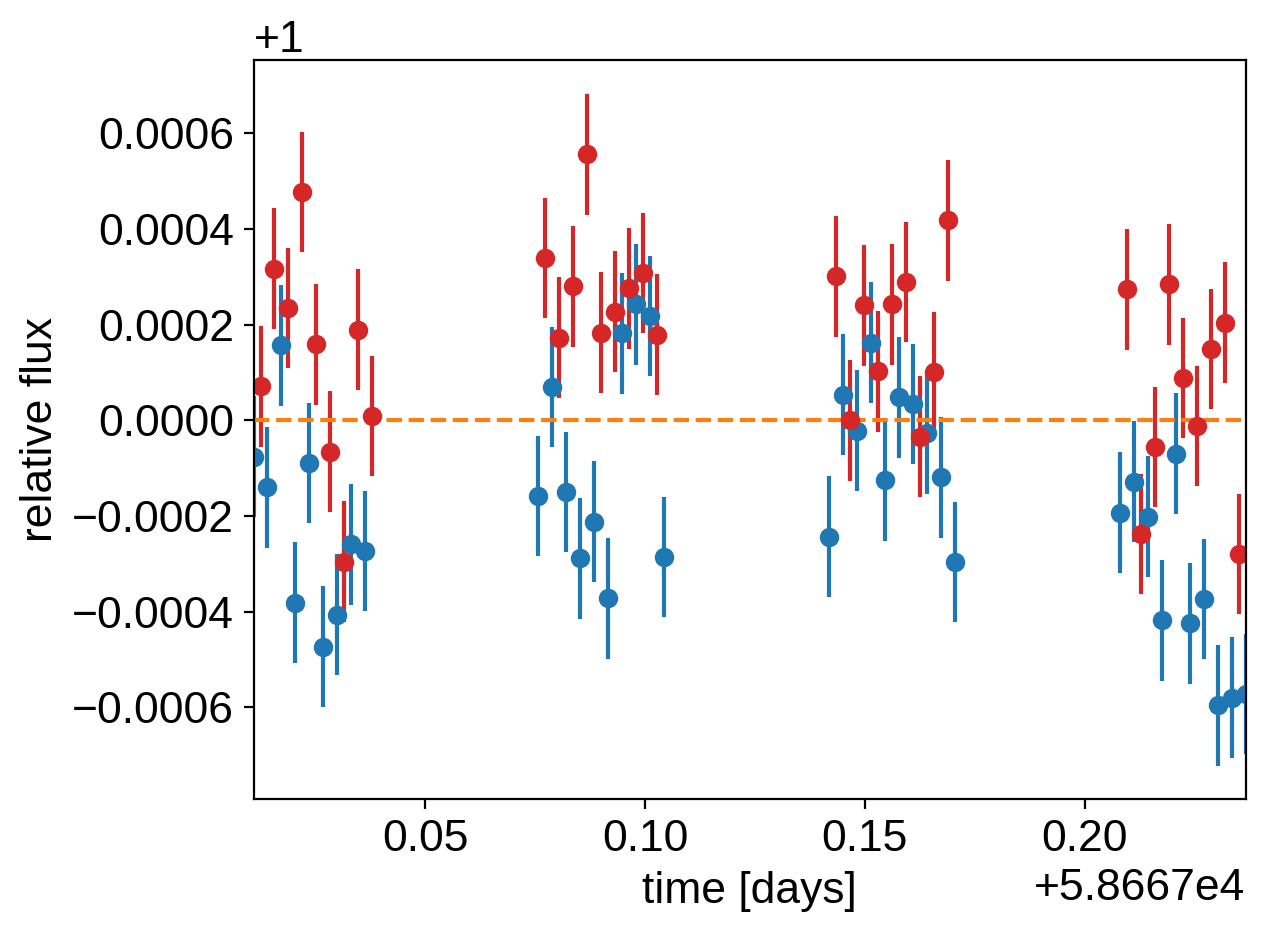

In [81]:
# Compute a limb-darkened light curve using starry
times = planet.times
u = []
flux = planet.normed_photometry_df['aperture_sum_16x51']
yerr = planet.normed_uncertainty_df['aperture_sum_16x51']

plt.errorbar(times[idx_fwd], flux[idx_fwd], yerr[idx_fwd], fmt='o', color="C0")
plt.errorbar(times[idx_rev], flux[idx_rev], yerr[idx_rev], fmt='o', color="C3")
plt.axhline(1.0, ls='--', color='C1')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [82]:
np.random.seed(42)

time_med = np.median(times)
med_t_diff = np.median(np.diff(times))

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [83]:
print(f'This instance has {mp.cpu_count()} CPUs')

This instance has 16 CPUs


In [84]:
import pymc3 as pm
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]
t0 = time_med
edepth = np.sqrt(1000/1e6)

orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
injected_light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=times).eval().flatten()

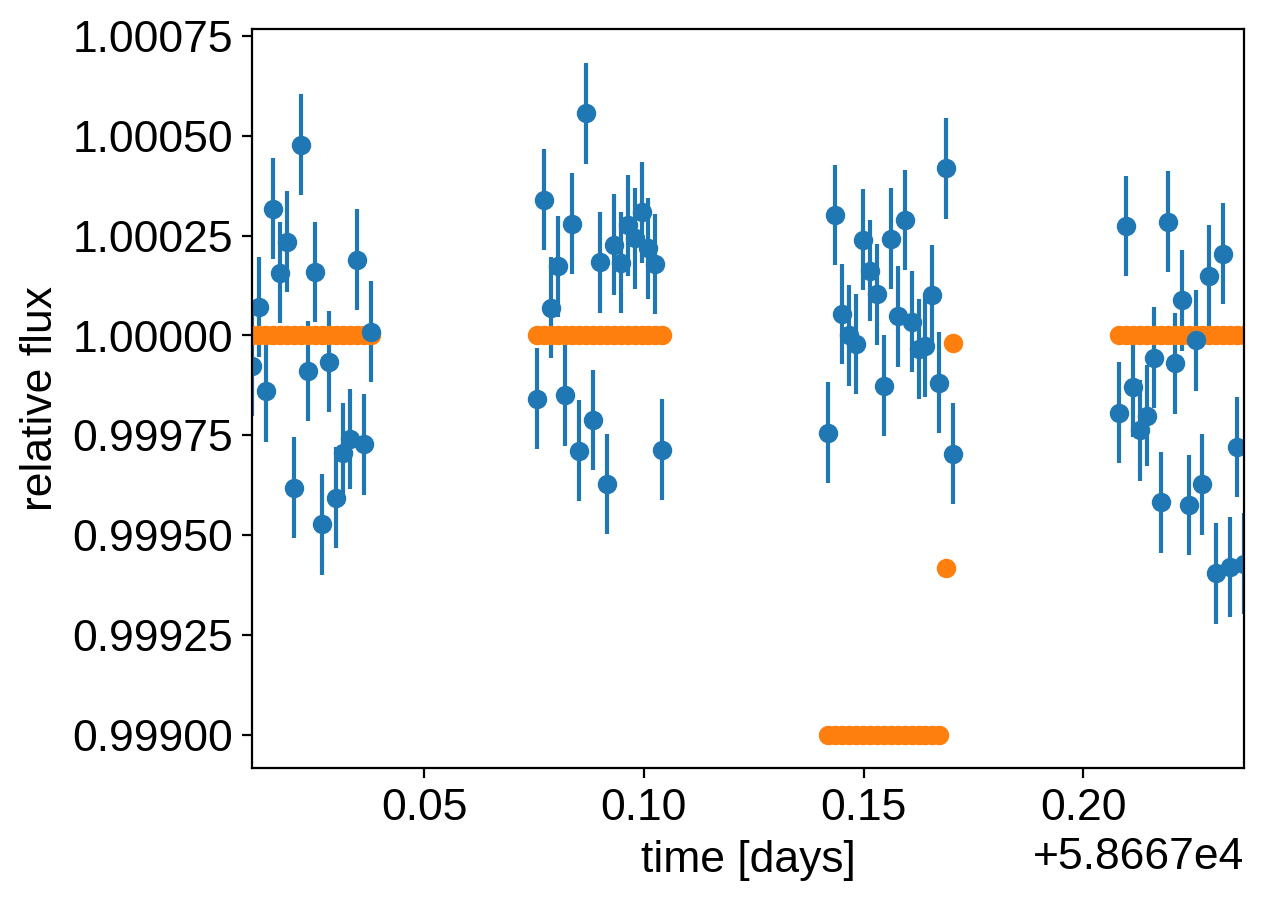

In [85]:
plt.errorbar(times, flux, yerr, fmt='o')
plt.plot(times, injected_light_curves+1,'o')
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(times.min(), times.max());

In [86]:
t0_wasp43 = 55528.3684  # exo.mast.stsci.edu
n_epochs = np.int(np.round(((time_med - t0_wasp43) / period)-0.5))
n_epochs, ((time_med - t0_wasp43) / period)
t0_guess = t0_wasp43 + (n_epochs+0.5) * period

# t0s = np.random.normal(t0_guess, 0.1*med_t_diff, size=2)
t0s = t0_guess

In [88]:
import joblib
from tqdm import tqdm

# Run 400 MCMCs

In [93]:
import pymc3 as pm
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]

# oot_guess = np.median(np.r_[flux[:2*18], flux[-18:]])
# stellar_variance = np.std(np.r_[flux[:2*18], flux[-18:]])
data = flux * (injected_light_curves+1)# - oot_guess
t0 = t0_guess

def run_pymc3(t, data, yerr, t0, u, period, b, xcenters=None,
              tune=3000, draws=3000, target_accept=0.9):
    
    with pm.Model() as model:

        # The baseline flux
        mean = pm.Normal("mean", mu=1.0, sd=1.0)
        # mean_xcenter = pm.Normal("mean_xcenter", mu=0.0, sd=1.0)
        # The time of a reference transit for each planet
        # t0 = pm.Normal("t0", mu=t0_guess, sd=1e-6)  # , shape=2)

        # The log period; also tracking the period itself
        # logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
        # period = pm.Deterministic("period", pm.math.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        # u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

        edepth = pm.Uniform("edepth", lower=1e-6, upper=0.1)  # , shape=2)  #, testval=np.array([0.04, 0.06]))
        edepth = np.sqrt(edepth)
        # b = xo.distributions.ImpactParameter("b", ror=r, shape=2, testval=np.random.rand(2))

        slope = pm.Uniform("slope", lower=-0.1, upper=0.1)
        slope_xcenter = pm.Uniform("slope_xcenter", lower=-0.1, upper=0.1)
        # intercept = pm.Uniform("intercept", lower=-0.1, upper=0.1)
        line = slope * (t-t0_guess) + mean
        # line_rev = slope * (t[idx_rev]-t0_guess) + mean
        
        line_xcenter = slope * (xcenters-np.median(xcenters)) # + mean_xcenter
        # line_xc_rev = slope * (xcenters[idx_rev]-np.median(xcenters)) + mean_xcenter

        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0s, b=b)

        # # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=t)
        # light_curves_rev = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=t[idx_rev])
        light_curve = pm.math.sum(light_curves, axis=-1) 
        # light_curve_rev = pm.math.sum(light_curves_rev, axis=-1) 

        # # Here we track the value of the model light curve for plotting
        # # purposes
        pm.Deterministic("light_curves", light_curves)
#         pm.Deterministic("light_curves_rev", light_curves_rev)

        # # In this line, we simulate the dataset that we will fit
        # # y = xo.eval_in_model(light_curve)
        # # y += yerr * np.random.randn(len(y))

        # # The likelihood function assuming known Gaussian uncertainty
        pm.Normal("obs", mu=light_curve + line + line_xcenter, sd=yerr, observed=data)
        # pm.Normal("obs_rev", mu=light_curve_rev + line[idx_rev] + line_xcenter[idx_rev], sd=yerr[idx_rev], observed=data[idx_rev])

        # # Fit for the maximum a posteriori parameters given the simuated dataset
        map_soln = xo.optimize(start=model.test_point)

        np.random.seed(42)

        trace = pm.sample(
            tune=tune,
            draws=draws,
            start=map_soln,
            chains=mp.cpu_count(),
            step=xo.get_dense_nuts_step(target_accept=target_accept),
            cores=mp.cpu_count()
        )
    
    return trace, map_soln

In [94]:
b = 0.66 # Hellier 2011
period = 0.813475  # days # exo.mast.stsci.edu
u = [0]

oot_guess = np.median(np.r_[flux[:2*18], flux[-18:]])
# stellar_variance = np.std(np.r_[flux[:2*18], flux[-18:]])
data = flux * (injected_light_curves+1)# - oot_guess
t0 = t0_guess

edepth = np.sqrt(1000/1e6)
orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
injected_light_curve = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=edepth, t=times).eval().flatten()

In [112]:
fine_snr_flux = planet.normed_photometry_df
fine_snr_uncs = planet.normed_uncertainty_df

n_columns = len(fine_snr_flux.columns)

aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns

xcenters = planet.photometry_df['xcenter']

fine_grain_mcmcs_w_xcenterfit = {}
for colname in aper_sum_columns:  # [fine_min_snr_colname]:  # 
    start = time()
    info_message(f'Working on {colname} for Trace MCMCs')
    data = fine_snr_flux[colname] * (injected_light_curve + 1.0)
    yerr = fine_snr_uncs[colname]
    
    trace, map_soln = run_pymc3(times, data, yerr, t0, u, period, b, xcenters=xcenters)
    fine_grain_mcmcs_w_xcenterfit[colname] = {}
    fine_grain_mcmcs_w_xcenterfit[colname]['trace'] = trace
    fine_grain_mcmcs_w_xcenterfit[colname]['map_soln'] = map_soln
    info_message(f'Completed {colname} for Trace MCMCs took {time()-start}')

filename = 'WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit.joblib.save'
filename = os.path.join(working_dir, filename)

info_message(f'Saving MCMCs to {filename}')
joblib.dump(fine_grain_mcmcs_w_xcenterfit, filename)

[INFO] Working on aperture_sum_11x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
147it [00:00, 318.78it/s, logp=4.568340e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1389107.8016965794 -> 456.8339878615012
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1703.44draws/s]


[INFO] Completed aperture_sum_11x41 for Trace MCMCs took 73.0391194820404
[INFO] Working on aperture_sum_12x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 162.51it/s, logp=4.567820e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389268.4190239562 -> 456.7820426932893
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1745.83draws/s]


[INFO] Completed aperture_sum_12x41 for Trace MCMCs took 68.72386336326599
[INFO] Working on aperture_sum_13x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
159it [00:00, 253.03it/s, logp=4.564267e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389307.7885569942 -> 456.42667251136885
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1709.38draws/s]


[INFO] Completed aperture_sum_13x41 for Trace MCMCs took 74.58853197097778
[INFO] Working on aperture_sum_14x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 85.00it/s, logp=4.564118e+02] 
message: Optimization terminated successfully.
logp: -1389339.5376023117 -> 456.4117597674832
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1721.68draws/s]


[INFO] Completed aperture_sum_14x41 for Trace MCMCs took 73.47406840324402
[INFO] Working on aperture_sum_15x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 182.54it/s, logp=4.559992e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389351.6497328423 -> 455.99920812332124
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1669.31draws/s]


[INFO] Completed aperture_sum_15x41 for Trace MCMCs took 75.55998587608337
[INFO] Working on aperture_sum_16x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 193.35it/s, logp=4.559934e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389414.1561553217 -> 455.99342670428496
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1778.19draws/s]


[INFO] Completed aperture_sum_16x41 for Trace MCMCs took 72.48455452919006
[INFO] Working on aperture_sum_17x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
121it [00:00, 204.69it/s, logp=4.557311e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389427.5257524296 -> 455.7311339203374
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1743.30draws/s]


[INFO] Completed aperture_sum_17x41 for Trace MCMCs took 73.78668689727783
[INFO] Working on aperture_sum_18x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 179.15it/s, logp=4.557387e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389512.9208246693 -> 455.7386672480471
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1794.24draws/s]


[INFO] Completed aperture_sum_18x41 for Trace MCMCs took 68.45518612861633
[INFO] Working on aperture_sum_19x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
80it [00:00, 161.10it/s, logp=4.555482e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389562.1652221712 -> 455.5482321986242
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1788.09draws/s]


[INFO] Completed aperture_sum_19x41 for Trace MCMCs took 72.52028250694275
[INFO] Working on aperture_sum_20x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 163.63it/s, logp=4.556171e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389644.4503555829 -> 455.6171237207977
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1777.64draws/s]


[INFO] Completed aperture_sum_20x41 for Trace MCMCs took 73.26167368888855
[INFO] Working on aperture_sum_21x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 179.21it/s, logp=4.553944e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389668.7622286754 -> 455.39442843648334
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1768.87draws/s]


[INFO] Completed aperture_sum_21x41 for Trace MCMCs took 69.46104979515076
[INFO] Working on aperture_sum_22x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
67it [00:00, 139.34it/s, logp=4.552853e+02]
message: Optimization terminated successfully.
logp: -1389716.2236846243 -> 455.285334166837
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1782.10draws/s]


[INFO] Completed aperture_sum_22x41 for Trace MCMCs took 73.23236203193665
[INFO] Working on aperture_sum_23x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
173it [00:00, 241.70it/s, logp=4.551175e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389722.738691922 -> 455.1175417590789
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1800.51draws/s]


[INFO] Completed aperture_sum_23x41 for Trace MCMCs took 73.21246790885925
[INFO] Working on aperture_sum_24x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 167.13it/s, logp=4.551657e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389799.6977481602 -> 455.1657056618134
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1807.73draws/s]


[INFO] Completed aperture_sum_24x41 for Trace MCMCs took 68.23483443260193
[INFO] Working on aperture_sum_25x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 176.20it/s, logp=4.550449e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1389903.6225241243 -> 455.0449496816668
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1790.04draws/s]


[INFO] Completed aperture_sum_25x41 for Trace MCMCs took 74.15041065216064
[INFO] Working on aperture_sum_26x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 190.86it/s, logp=4.550232e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390003.0145049584 -> 455.02321626374754
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1734.72draws/s]


[INFO] Completed aperture_sum_26x41 for Trace MCMCs took 70.62124466896057
[INFO] Working on aperture_sum_27x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 163.75it/s, logp=4.548546e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390035.910172193 -> 454.8546208195563
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:51<00:00, 1854.39draws/s]


[INFO] Completed aperture_sum_27x41 for Trace MCMCs took 72.32494163513184
[INFO] Working on aperture_sum_28x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
113it [00:00, 189.32it/s, logp=4.547809e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390046.8585670101 -> 454.7809060341224
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1749.62draws/s]


[INFO] Completed aperture_sum_28x41 for Trace MCMCs took 70.32937455177307
[INFO] Working on aperture_sum_29x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
156it [00:00, 230.21it/s, logp=4.546223e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390043.5963273747 -> 454.62229910252455
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1805.06draws/s]


[INFO] Completed aperture_sum_29x41 for Trace MCMCs took 74.14984726905823
[INFO] Working on aperture_sum_30x41 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 181.06it/s, logp=4.545327e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390074.7096404333 -> 454.53266651324145
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1746.70draws/s]


[INFO] Completed aperture_sum_30x41 for Trace MCMCs took 70.3446741104126
[INFO] Working on aperture_sum_11x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
134it [00:00, 210.59it/s, logp=4.574787e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390203.8606165245 -> 457.4786677311761
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1722.64draws/s]


[INFO] Completed aperture_sum_11x42 for Trace MCMCs took 76.95456290245056
[INFO] Working on aperture_sum_12x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
122it [00:00, 218.93it/s, logp=4.574234e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390366.6771723775 -> 457.4233995512013
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1810.04draws/s]


[INFO] Completed aperture_sum_12x42 for Trace MCMCs took 68.52024626731873
[INFO] Working on aperture_sum_13x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
106it [00:00, 188.31it/s, logp=4.570591e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390405.1979677782 -> 457.059142068803
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1797.69draws/s]


[INFO] Completed aperture_sum_13x42 for Trace MCMCs took 68.7799425125122
[INFO] Working on aperture_sum_14x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
117it [00:00, 191.62it/s, logp=4.570441e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390436.2387545903 -> 457.044072270936
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1750.32draws/s]


[INFO] Completed aperture_sum_14x42 for Trace MCMCs took 77.04128360748291
[INFO] Working on aperture_sum_15x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
119it [00:00, 209.17it/s, logp=4.566389e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390446.6405921497 -> 456.6389472989355
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:52<00:00, 1811.63draws/s]


[INFO] Completed aperture_sum_15x42 for Trace MCMCs took 68.45579552650452
[INFO] Working on aperture_sum_16x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
108it [00:00, 198.92it/s, logp=4.566328e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390508.882733824 -> 456.6328380529278
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1745.37draws/s]


[INFO] Completed aperture_sum_16x42 for Trace MCMCs took 77.05752491950989
[INFO] Working on aperture_sum_17x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
83it [00:00, 161.84it/s, logp=4.563620e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390520.536977139 -> 456.36200387413635
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1707.16draws/s]


[INFO] Completed aperture_sum_17x42 for Trace MCMCs took 71.68582081794739
[INFO] Working on aperture_sum_18x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
123it [00:00, 213.48it/s, logp=4.563625e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390598.6289519784 -> 456.36253556524395
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1782.48draws/s]


[INFO] Completed aperture_sum_18x42 for Trace MCMCs took 76.58996772766113
[INFO] Working on aperture_sum_19x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 181.38it/s, logp=4.561699e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390646.7835453718 -> 456.1698545127841
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1723.02draws/s]


[INFO] Completed aperture_sum_19x42 for Trace MCMCs took 71.3023452758789
[INFO] Working on aperture_sum_20x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
107it [00:00, 187.48it/s, logp=4.562343e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390732.5849916372 -> 456.23431349669704
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1765.09draws/s]


[INFO] Completed aperture_sum_20x42 for Trace MCMCs took 70.03947019577026
[INFO] Working on aperture_sum_21x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
105it [00:00, 195.10it/s, logp=4.560024e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390759.5155631558 -> 456.0023887496295
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1715.69draws/s]


[INFO] Completed aperture_sum_21x42 for Trace MCMCs took 79.24965262413025
[INFO] Working on aperture_sum_22x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 84.57it/s, logp=4.558935e+02] 
message: Optimization terminated successfully.
logp: -1390811.1408960265 -> 455.8934757546309
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1731.94draws/s]


[INFO] Completed aperture_sum_22x42 for Trace MCMCs took 71.16134786605835
[INFO] Working on aperture_sum_23x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 174.43it/s, logp=4.557361e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390821.4433039378 -> 455.7360925417013
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1730.28draws/s]


[INFO] Completed aperture_sum_23x42 for Trace MCMCs took 71.14171552658081
[INFO] Working on aperture_sum_24x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
147it [00:00, 219.22it/s, logp=4.557910e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1390901.0609297259 -> 455.79104485801565
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1744.68draws/s]


[INFO] Completed aperture_sum_24x42 for Trace MCMCs took 78.93075442314148
[INFO] Working on aperture_sum_25x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 82.89it/s, logp=4.556681e+02] 
message: Optimization terminated successfully.
logp: -1391003.6108475577 -> 455.66812982250633
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1753.03draws/s]


[INFO] Completed aperture_sum_25x42 for Trace MCMCs took 70.38021183013916
[INFO] Working on aperture_sum_26x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 186.29it/s, logp=4.556439e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391097.5406547475 -> 455.64393955938857
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1781.20draws/s]


[INFO] Completed aperture_sum_26x42 for Trace MCMCs took 69.59714388847351
[INFO] Working on aperture_sum_27x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
34it [00:00, 92.03it/s, logp=4.554717e+02] 
message: Optimization terminated successfully.
logp: -1391124.4404527864 -> 455.4717485390769
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1696.06draws/s]


[INFO] Completed aperture_sum_27x42 for Trace MCMCs took 80.51202130317688
[INFO] Working on aperture_sum_28x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 174.17it/s, logp=4.553964e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391134.0433669616 -> 455.3964101137723
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1706.08draws/s]


[INFO] Completed aperture_sum_28x42 for Trace MCMCs took 72.09138131141663
[INFO] Working on aperture_sum_29x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
180it [00:00, 244.02it/s, logp=4.552417e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391132.0958081938 -> 455.2417300079119
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1768.68draws/s]


[INFO] Completed aperture_sum_29x42 for Trace MCMCs took 70.42390871047974
[INFO] Working on aperture_sum_30x42 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
117it [00:00, 202.74it/s, logp=4.551555e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391165.0455595409 -> 455.15553980575527
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1784.88draws/s]


[INFO] Completed aperture_sum_30x42 for Trace MCMCs took 78.67169904708862
[INFO] Working on aperture_sum_11x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 166.97it/s, logp=4.578082e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391211.431478647 -> 457.8081713971412
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1698.22draws/s]


[INFO] Completed aperture_sum_11x43 for Trace MCMCs took 72.5315363407135
[INFO] Working on aperture_sum_12x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 83.88it/s, logp=4.577439e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1391373.6076674296 -> 457.7438796498433
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:53<00:00, 1796.36draws/s]


[INFO] Completed aperture_sum_12x43 for Trace MCMCs took 69.17990136146545
[INFO] Working on aperture_sum_13x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
119it [00:00, 201.21it/s, logp=4.573774e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391408.1263218152 -> 457.3774201993448
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1771.42draws/s]


[INFO] Completed aperture_sum_13x43 for Trace MCMCs took 79.70609045028687
[INFO] Working on aperture_sum_14x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 187.95it/s, logp=4.573660e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391437.139380956 -> 457.3660011687375
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1744.69draws/s]


[INFO] Completed aperture_sum_14x43 for Trace MCMCs took 70.9517149925232
[INFO] Working on aperture_sum_15x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 181.30it/s, logp=4.569593e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391444.5231502932 -> 456.95927052585074
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1765.44draws/s]


[INFO] Completed aperture_sum_15x43 for Trace MCMCs took 70.40994954109192
[INFO] Working on aperture_sum_16x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
38it [00:00, 98.15it/s, logp=4.569486e+02] 
message: Optimization terminated successfully.
logp: -1391502.907773264 -> 456.94864764156813
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1774.25draws/s]


[INFO] Completed aperture_sum_16x43 for Trace MCMCs took 69.94848012924194
[INFO] Working on aperture_sum_17x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
132it [00:00, 300.22it/s, logp=4.566660e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1391514.4038048936 -> 456.66604530646146
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1700.37draws/s]


[INFO] Completed aperture_sum_17x43 for Trace MCMCs took 82.67217206954956
[INFO] Working on aperture_sum_18x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
80it [00:00, 159.31it/s, logp=4.566546e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391593.4855934652 -> 456.65459029237473
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1718.60draws/s]


[INFO] Completed aperture_sum_18x43 for Trace MCMCs took 71.99854445457458
[INFO] Working on aperture_sum_19x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 179.37it/s, logp=4.564493e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391642.4137487176 -> 456.44932720368405
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1733.20draws/s]


[INFO] Completed aperture_sum_19x43 for Trace MCMCs took 71.57173371315002
[INFO] Working on aperture_sum_20x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
139it [00:00, 221.32it/s, logp=4.564998e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391733.5472813733 -> 456.4997882292172
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1738.66draws/s]


[INFO] Completed aperture_sum_20x43 for Trace MCMCs took 71.45624256134033
[INFO] Working on aperture_sum_21x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 167.26it/s, logp=4.562585e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391766.9581974044 -> 456.25851284058984
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1683.64draws/s]


[INFO] Completed aperture_sum_21x43 for Trace MCMCs took 84.04383778572083
[INFO] Working on aperture_sum_22x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 166.40it/s, logp=4.561497e+02]
message: Optimization terminated successfully.
logp: -1391822.2826341346 -> 456.1496955673708
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1675.77draws/s]


[INFO] Completed aperture_sum_22x43 for Trace MCMCs took 73.56662225723267
[INFO] Working on aperture_sum_23x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
170it [00:00, 241.86it/s, logp=4.559931e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1391838.3806642469 -> 455.9930870498025
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1746.02draws/s]


[INFO] Completed aperture_sum_23x43 for Trace MCMCs took 71.44353413581848
[INFO] Working on aperture_sum_24x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 166.62it/s, logp=4.560429e+02]
message: Optimization terminated successfully.
logp: -1391922.7035069955 -> 456.0429149285965
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1754.08draws/s]


[INFO] Completed aperture_sum_24x43 for Trace MCMCs took 82.72757387161255
[INFO] Working on aperture_sum_25x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 173.07it/s, logp=4.559211e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392024.9632675843 -> 455.9211054784391
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1666.63draws/s]


[INFO] Completed aperture_sum_25x43 for Trace MCMCs took 74.06899070739746
[INFO] Working on aperture_sum_26x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
105it [00:00, 175.92it/s, logp=4.559079e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392117.0348365293 -> 455.9078972967109
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1706.57draws/s]


[INFO] Completed aperture_sum_26x43 for Trace MCMCs took 72.81380081176758
[INFO] Working on aperture_sum_27x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
165it [00:00, 260.37it/s, logp=4.557415e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392140.234962949 -> 455.7415401424904
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1764.70draws/s]


[INFO] Completed aperture_sum_27x43 for Trace MCMCs took 70.93453049659729
[INFO] Working on aperture_sum_28x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
275it [00:00, 342.41it/s, logp=4.556633e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392147.8763720721 -> 455.6633411656085
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1730.19draws/s]


[INFO] Completed aperture_sum_28x43 for Trace MCMCs took 72.33459901809692
[INFO] Working on aperture_sum_29x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 188.50it/s, logp=4.555002e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392147.1976560806 -> 455.5001902119865
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1653.31draws/s]


[INFO] Completed aperture_sum_29x43 for Trace MCMCs took 87.00852131843567
[INFO] Working on aperture_sum_30x43 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
81it [00:00, 170.53it/s, logp=4.554117e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392183.092109285 -> 455.41171390372483
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1722.52draws/s]


[INFO] Completed aperture_sum_30x43 for Trace MCMCs took 72.23053216934204
[INFO] Working on aperture_sum_11x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 174.81it/s, logp=4.577982e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392286.3488185059 -> 457.79823929267405
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1754.40draws/s]


[INFO] Completed aperture_sum_11x44 for Trace MCMCs took 71.27918148040771
[INFO] Working on aperture_sum_12x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 96.80it/s, logp=4.577282e+02] 
message: Optimization terminated successfully.
logp: -1392446.2933306335 -> 457.7281883851905
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1722.88draws/s]


[INFO] Completed aperture_sum_12x44 for Trace MCMCs took 71.99671649932861
[INFO] Working on aperture_sum_13x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
115it [00:00, 193.68it/s, logp=4.573625e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392475.966339691 -> 457.362462872443
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1700.62draws/s]


[INFO] Completed aperture_sum_13x44 for Trace MCMCs took 86.48174381256104
[INFO] Working on aperture_sum_14x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
110it [00:00, 184.19it/s, logp=4.573601e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392503.5018691316 -> 457.3601158014673
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1649.51draws/s]


[INFO] Completed aperture_sum_14x44 for Trace MCMCs took 75.09962058067322
[INFO] Working on aperture_sum_15x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 199.39it/s, logp=4.569765e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392508.2962572137 -> 456.9764810205265
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1734.85draws/s]


[INFO] Completed aperture_sum_15x44 for Trace MCMCs took 71.99671792984009
[INFO] Working on aperture_sum_16x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 168.12it/s, logp=4.570119e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392563.1703345212 -> 457.0119428543701
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:54<00:00, 1774.80draws/s]


[INFO] Completed aperture_sum_16x44 for Trace MCMCs took 70.79053163528442
[INFO] Working on aperture_sum_17x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
184it [00:00, 252.94it/s, logp=4.567570e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392576.1171271217 -> 456.75700126228844
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1721.85draws/s]


[INFO] Completed aperture_sum_17x44 for Trace MCMCs took 72.69166946411133
[INFO] Working on aperture_sum_18x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
67it [00:00, 142.69it/s, logp=4.567530e+02]
message: Optimization terminated successfully.
logp: -1392657.323325798 -> 456.7529767248008
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1601.27draws/s]


[INFO] Completed aperture_sum_18x44 for Trace MCMCs took 90.50687026977539
[INFO] Working on aperture_sum_19x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 188.42it/s, logp=4.565432e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392704.7836293906 -> 456.5432236993148
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1659.82draws/s]


[INFO] Completed aperture_sum_19x44 for Trace MCMCs took 74.7756757736206
[INFO] Working on aperture_sum_20x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 172.79it/s, logp=4.565795e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392799.4874845513 -> 456.57954507464984
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1710.15draws/s]


[INFO] Completed aperture_sum_20x44 for Trace MCMCs took 72.94358396530151
[INFO] Working on aperture_sum_21x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 168.31it/s, logp=4.563276e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392837.8511088537 -> 456.3275827585665
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1684.29draws/s]


[INFO] Completed aperture_sum_21x44 for Trace MCMCs took 73.85991716384888
[INFO] Working on aperture_sum_22x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
80it [00:00, 160.19it/s, logp=4.562192e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392894.3018623479 -> 456.21917747186563
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1723.03draws/s]


[INFO] Completed aperture_sum_22x44 for Trace MCMCs took 87.19784116744995
[INFO] Working on aperture_sum_23x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
118it [00:00, 216.78it/s, logp=4.560583e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1392916.3739858556 -> 456.0582690602172
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1639.53draws/s]


[INFO] Completed aperture_sum_23x44 for Trace MCMCs took 75.59297132492065
[INFO] Working on aperture_sum_24x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
45it [00:00, 108.38it/s, logp=4.560992e+02]
message: Optimization terminated successfully.
logp: -1393006.1119793798 -> 456.0991789229378
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1669.63draws/s]


[INFO] Completed aperture_sum_24x44 for Trace MCMCs took 74.48034906387329
[INFO] Working on aperture_sum_25x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 187.36it/s, logp=4.559768e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393109.9203413583 -> 455.9768428367658
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1730.14draws/s]


[INFO] Completed aperture_sum_25x44 for Trace MCMCs took 72.45068550109863
[INFO] Working on aperture_sum_26x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 195.44it/s, logp=4.559687e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393203.4946292783 -> 455.9687148291469
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1627.36draws/s]


[INFO] Completed aperture_sum_26x44 for Trace MCMCs took 75.96845722198486
[INFO] Working on aperture_sum_27x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 174.62it/s, logp=4.558028e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393224.1152122004 -> 455.8028002972314
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1713.65draws/s]


[INFO] Completed aperture_sum_27x44 for Trace MCMCs took 88.64257526397705
[INFO] Working on aperture_sum_28x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 178.20it/s, logp=4.557220e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393229.4392888618 -> 455.72195040290035
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1678.36draws/s]


[INFO] Completed aperture_sum_28x44 for Trace MCMCs took 74.42283916473389
[INFO] Working on aperture_sum_29x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
145it [00:00, 220.90it/s, logp=4.555568e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393229.8932273323 -> 455.55677421620925
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1691.04draws/s]


[INFO] Completed aperture_sum_29x44 for Trace MCMCs took 74.27134156227112
[INFO] Working on aperture_sum_30x44 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 239.10it/s, logp=4.554721e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393268.301982572 -> 455.47211729884185
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1689.51draws/s]


[INFO] Completed aperture_sum_30x44 for Trace MCMCs took 73.75030493736267
[INFO] Working on aperture_sum_11x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
84it [00:00, 191.17it/s, logp=4.575916e+02] 
message: Optimization terminated successfully.
logp: -1393278.649617836 -> 457.5916126248857
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1715.04draws/s]


[INFO] Completed aperture_sum_11x45 for Trace MCMCs took 72.99035954475403
[INFO] Working on aperture_sum_12x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 95.42it/s, logp=4.575270e+02] 
message: Optimization terminated successfully.
logp: -1393438.5375362425 -> 457.5270446339379
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1705.18draws/s]


[INFO] Completed aperture_sum_12x45 for Trace MCMCs took 73.36219549179077
[INFO] Working on aperture_sum_13x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
166it [00:00, 243.57it/s, logp=4.571673e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393465.7828687746 -> 457.1673185994177
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1685.50draws/s]


[INFO] Completed aperture_sum_13x45 for Trace MCMCs took 90.89489245414734
[INFO] Working on aperture_sum_14x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 166.10it/s, logp=4.571675e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393491.1542839324 -> 457.167542019243
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1652.12draws/s]


[INFO] Completed aperture_sum_14x45 for Trace MCMCs took 75.7301983833313
[INFO] Working on aperture_sum_15x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 171.68it/s, logp=4.568400e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393494.8626354102 -> 456.83995201532815
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1698.12draws/s]


[INFO] Completed aperture_sum_15x45 for Trace MCMCs took 73.98175954818726
[INFO] Working on aperture_sum_16x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 180.97it/s, logp=4.569998e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393547.7222292882 -> 456.9998079861083
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1733.08draws/s]


[INFO] Completed aperture_sum_16x45 for Trace MCMCs took 72.69118189811707
[INFO] Working on aperture_sum_17x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 173.96it/s, logp=4.568289e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393558.5303744725 -> 456.82888726974994
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1663.72draws/s]


[INFO] Completed aperture_sum_17x45 for Trace MCMCs took 75.02374744415283
[INFO] Working on aperture_sum_18x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 80.54it/s, logp=4.568666e+02] 
message: Optimization terminated successfully.
logp: -1393640.5159092422 -> 456.8665922179053
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1636.63draws/s]


[INFO] Completed aperture_sum_18x45 for Trace MCMCs took 93.23645520210266
[INFO] Working on aperture_sum_19x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
139it [00:00, 220.21it/s, logp=4.566724e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393688.7871475806 -> 456.67244639279863
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1644.87draws/s]


[INFO] Completed aperture_sum_19x45 for Trace MCMCs took 76.02907633781433
[INFO] Working on aperture_sum_20x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
195it [00:00, 268.29it/s, logp=4.567020e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393788.1894737799 -> 456.70197632927693
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:55<00:00, 1716.35draws/s]


[INFO] Completed aperture_sum_20x45 for Trace MCMCs took 73.89762496948242
[INFO] Working on aperture_sum_21x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
118it [00:00, 225.78it/s, logp=4.564430e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393833.255122217 -> 456.44298755576165
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1647.72draws/s]


[INFO] Completed aperture_sum_21x45 for Trace MCMCs took 75.81585383415222
[INFO] Working on aperture_sum_22x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
176it [00:00, 243.37it/s, logp=4.563304e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1393890.9575976105 -> 456.3304133086082
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1673.86draws/s]


[INFO] Completed aperture_sum_22x45 for Trace MCMCs took 75.1212227344513
[INFO] Working on aperture_sum_23x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 81.05it/s, logp=4.561596e+02] 
message: Optimization terminated successfully.
logp: -1393913.6678583308 -> 456.1595792018857
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1632.53draws/s]


[INFO] Completed aperture_sum_23x45 for Trace MCMCs took 76.26178741455078
[INFO] Working on aperture_sum_24x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
147it [00:00, 232.08it/s, logp=4.561925e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394003.9570014286 -> 456.19246561919283
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1669.67draws/s]


[INFO] Completed aperture_sum_24x45 for Trace MCMCs took 93.80517244338989
[INFO] Working on aperture_sum_25x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
177it [00:00, 247.40it/s, logp=4.560623e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394108.8945991849 -> 456.0622897347838
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1593.89draws/s]


[INFO] Completed aperture_sum_25x45 for Trace MCMCs took 78.20406222343445
[INFO] Working on aperture_sum_26x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
83it [00:00, 159.90it/s, logp=4.560450e+02]
message: Optimization terminated successfully.
logp: -1394202.5043883382 -> 456.0449950892955
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1611.91draws/s]


[INFO] Completed aperture_sum_26x45 for Trace MCMCs took 77.40092134475708
[INFO] Working on aperture_sum_27x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
45it [00:00, 111.91it/s, logp=4.558767e+02]
message: Optimization terminated successfully.
logp: -1394217.1496714177 -> 455.87671262918656
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1615.94draws/s]


[INFO] Completed aperture_sum_27x45 for Trace MCMCs took 76.94092297554016
[INFO] Working on aperture_sum_28x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 180.09it/s, logp=4.558009e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394216.3280935907 -> 455.80087003309797
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1661.37draws/s]


[INFO] Completed aperture_sum_28x45 for Trace MCMCs took 75.45739006996155
[INFO] Working on aperture_sum_29x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
35it [00:00, 91.47it/s, logp=4.556447e+02] 
message: Optimization terminated successfully.
logp: -1394213.3773994485 -> 455.64466104259384
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1659.13draws/s]


[INFO] Completed aperture_sum_29x45 for Trace MCMCs took 75.377934217453
[INFO] Working on aperture_sum_30x45 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
175it [00:00, 255.03it/s, logp=4.555688e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394246.6702024275 -> 455.568782704273
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:56<00:00, 1698.09draws/s]


[INFO] Completed aperture_sum_30x45 for Trace MCMCs took 94.85096478462219
[INFO] Working on aperture_sum_11x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
121it [00:00, 202.94it/s, logp=4.575581e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394039.0866773853 -> 457.5581173942301
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1652.23draws/s]


[INFO] Completed aperture_sum_11x46 for Trace MCMCs took 76.20706295967102
[INFO] Working on aperture_sum_12x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 184.53it/s, logp=4.575017e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394199.7978517218 -> 457.5017144035082
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1669.93draws/s]


[INFO] Completed aperture_sum_12x46 for Trace MCMCs took 75.65911626815796
[INFO] Working on aperture_sum_13x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
126it [00:00, 251.47it/s, logp=4.571505e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1394226.1239567534 -> 457.15053423515616
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1504.07draws/s]


[INFO] Completed aperture_sum_13x46 for Trace MCMCs took 81.82016968727112
[INFO] Working on aperture_sum_14x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 172.31it/s, logp=4.571500e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394249.4297265303 -> 457.1500060114442
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1672.14draws/s]


[INFO] Completed aperture_sum_14x46 for Trace MCMCs took 75.37155795097351
[INFO] Working on aperture_sum_15x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 178.28it/s, logp=4.568556e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394252.35971195 -> 456.85564859063356
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1642.54draws/s]


[INFO] Completed aperture_sum_15x46 for Trace MCMCs took 76.33102512359619
[INFO] Working on aperture_sum_16x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 167.15it/s, logp=4.570970e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394303.3535647576 -> 457.09695719364936
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1640.36draws/s]


[INFO] Completed aperture_sum_16x46 for Trace MCMCs took 76.50424909591675
[INFO] Working on aperture_sum_17x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
193it [00:00, 270.27it/s, logp=4.569772e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394311.223389499 -> 456.9772070939686
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1632.08draws/s]


[INFO] Completed aperture_sum_17x46 for Trace MCMCs took 98.0475914478302
[INFO] Working on aperture_sum_18x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
38it [00:00, 92.26it/s, logp=4.570389e+02] 
message: Optimization terminated successfully.
logp: -1394394.252114992 -> 457.0388507120915
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1649.00draws/s]


[INFO] Completed aperture_sum_18x46 for Trace MCMCs took 76.4651939868927
[INFO] Working on aperture_sum_19x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
139it [00:00, 214.67it/s, logp=4.568495e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394444.9405878931 -> 456.8494949213098
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1630.16draws/s]


[INFO] Completed aperture_sum_19x46 for Trace MCMCs took 77.24567985534668
[INFO] Working on aperture_sum_20x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 180.74it/s, logp=4.568686e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394550.4032368632 -> 456.8686411062212
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1645.64draws/s]


[INFO] Completed aperture_sum_20x46 for Trace MCMCs took 76.4919068813324
[INFO] Working on aperture_sum_21x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
194it [00:00, 262.68it/s, logp=4.566043e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394603.9904788507 -> 456.60427050220665
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1591.64draws/s]


[INFO] Completed aperture_sum_21x46 for Trace MCMCs took 78.6384346485138
[INFO] Working on aperture_sum_22x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
34it [00:00, 92.26it/s, logp=4.564898e+02] 
message: Optimization terminated successfully.
logp: -1394664.8512474145 -> 456.4898460350042
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1649.62draws/s]


[INFO] Completed aperture_sum_22x46 for Trace MCMCs took 76.18214225769043
[INFO] Working on aperture_sum_23x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 177.10it/s, logp=4.563153e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394685.1182285172 -> 456.3153347878094
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1637.81draws/s]


[INFO] Completed aperture_sum_23x46 for Trace MCMCs took 76.76675462722778
[INFO] Working on aperture_sum_24x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 179.13it/s, logp=4.563507e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394771.2700750078 -> 456.3506925484761
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1588.55draws/s]


[INFO] Completed aperture_sum_24x46 for Trace MCMCs took 100.45843029022217
[INFO] Working on aperture_sum_25x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 161.34it/s, logp=4.562224e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394874.187334849 -> 456.2223820604437
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1592.20draws/s]


[INFO] Completed aperture_sum_25x46 for Trace MCMCs took 78.76214361190796
[INFO] Working on aperture_sum_26x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 173.90it/s, logp=4.562031e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394964.423185807 -> 456.20309086998935
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1631.78draws/s]


[INFO] Completed aperture_sum_26x46 for Trace MCMCs took 77.27910923957825
[INFO] Working on aperture_sum_27x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
108it [00:00, 189.11it/s, logp=4.560330e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394971.4762859945 -> 456.0330219502056
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1654.64draws/s]


[INFO] Completed aperture_sum_27x46 for Trace MCMCs took 76.36047029495239
[INFO] Working on aperture_sum_28x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
34it [00:00, 88.09it/s, logp=4.559551e+02] 
message: Optimization terminated successfully.
logp: -1394964.029804808 -> 455.9551425390684
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1628.84draws/s]


[INFO] Completed aperture_sum_28x46 for Trace MCMCs took 77.11802697181702
[INFO] Working on aperture_sum_29x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 179.62it/s, logp=4.557995e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394955.733840566 -> 455.7995319210702
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1631.75draws/s]


[INFO] Completed aperture_sum_29x46 for Trace MCMCs took 77.17743515968323
[INFO] Working on aperture_sum_30x46 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 166.19it/s, logp=4.557263e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394981.6194438254 -> 455.7262686810258
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1677.31draws/s]


[INFO] Completed aperture_sum_30x46 for Trace MCMCs took 75.58437705039978
[INFO] Working on aperture_sum_11x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
112it [00:00, 189.98it/s, logp=4.573601e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1394874.199275411 -> 457.36013282909545
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1591.15draws/s]


[INFO] Completed aperture_sum_11x47 for Trace MCMCs took 102.22331428527832
[INFO] Working on aperture_sum_12x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
75it [00:00, 151.63it/s, logp=4.573101e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395030.1268047127 -> 457.3100672478786
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1586.00draws/s]


[INFO] Completed aperture_sum_12x47 for Trace MCMCs took 79.22633695602417
[INFO] Working on aperture_sum_13x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 174.10it/s, logp=4.569651e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395055.337569984 -> 456.9650966601799
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1629.97draws/s]


[INFO] Completed aperture_sum_13x47 for Trace MCMCs took 77.49257946014404
[INFO] Working on aperture_sum_14x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 189.31it/s, logp=4.569699e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395081.3346638915 -> 456.9698527106209
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1534.89draws/s]


[INFO] Completed aperture_sum_14x47 for Trace MCMCs took 81.01631355285645
[INFO] Working on aperture_sum_15x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 170.57it/s, logp=4.566712e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395086.1816071847 -> 456.67124837689835
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1640.51draws/s]


[INFO] Completed aperture_sum_15x47 for Trace MCMCs took 77.02251315116882
[INFO] Working on aperture_sum_16x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 182.42it/s, logp=4.569141e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395137.0553190599 -> 456.9140911513102
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1642.62draws/s]


[INFO] Completed aperture_sum_16x47 for Trace MCMCs took 77.06090712547302
[INFO] Working on aperture_sum_17x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 187.75it/s, logp=4.567858e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395143.1016652514 -> 456.7857973406812
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1576.64draws/s]


[INFO] Completed aperture_sum_17x47 for Trace MCMCs took 79.5467267036438
[INFO] Working on aperture_sum_18x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
34it [00:00, 93.64it/s, logp=4.568425e+02] 
message: Optimization terminated successfully.
logp: -1395226.6058955977 -> 456.84254413499383
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1594.70draws/s]


[INFO] Completed aperture_sum_18x47 for Trace MCMCs took 102.81744766235352
[INFO] Working on aperture_sum_19x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
70it [00:00, 152.22it/s, logp=4.566424e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395279.978180947 -> 456.64241638097377
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1639.86draws/s]


[INFO] Completed aperture_sum_19x47 for Trace MCMCs took 77.52809929847717
[INFO] Working on aperture_sum_20x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 187.60it/s, logp=4.566444e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395390.3884520421 -> 456.64435818300007
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1621.82draws/s]


[INFO] Completed aperture_sum_20x47 for Trace MCMCs took 78.10423183441162
[INFO] Working on aperture_sum_21x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 170.37it/s, logp=4.563691e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395450.1474346628 -> 456.36909184249606
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1632.43draws/s]


[INFO] Completed aperture_sum_21x47 for Trace MCMCs took 77.62221789360046
[INFO] Working on aperture_sum_22x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 168.96it/s, logp=4.562493e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395517.7642683454 -> 456.2493115277786
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1645.56draws/s]


[INFO] Completed aperture_sum_22x47 for Trace MCMCs took 77.02312278747559
[INFO] Working on aperture_sum_23x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 182.71it/s, logp=4.560722e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395540.613771974 -> 456.0722189623587
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1614.10draws/s]


[INFO] Completed aperture_sum_23x47 for Trace MCMCs took 78.2727358341217
[INFO] Working on aperture_sum_24x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 170.40it/s, logp=4.561158e+02]
message: Optimization terminated successfully.
logp: -1395623.5671702216 -> 456.1158300475539
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1620.26draws/s]


[INFO] Completed aperture_sum_24x47 for Trace MCMCs took 77.99141836166382
[INFO] Working on aperture_sum_25x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
114it [00:00, 209.01it/s, logp=4.559979e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395725.174991754 -> 455.99785175910193
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1514.27draws/s]


[INFO] Completed aperture_sum_25x47 for Trace MCMCs took 108.17966771125793
[INFO] Working on aperture_sum_26x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
181it [00:00, 256.03it/s, logp=4.559852e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395815.6246253517 -> 455.9852408773311
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1571.83draws/s]


[INFO] Completed aperture_sum_26x47 for Trace MCMCs took 80.3584794998169
[INFO] Working on aperture_sum_27x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
190it [00:00, 252.60it/s, logp=4.558115e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395821.142054919 -> 455.81154541607344
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1605.60draws/s]


[INFO] Completed aperture_sum_27x47 for Trace MCMCs took 79.32472705841064
[INFO] Working on aperture_sum_28x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
163it [00:00, 239.01it/s, logp=4.557251e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395808.8586654766 -> 455.72507868593794
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1599.85draws/s]


[INFO] Completed aperture_sum_28x47 for Trace MCMCs took 79.28998851776123
[INFO] Working on aperture_sum_29x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 172.13it/s, logp=4.555623e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395794.8885186817 -> 455.56231505213043
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1630.26draws/s]


[INFO] Completed aperture_sum_29x47 for Trace MCMCs took 77.89669680595398
[INFO] Working on aperture_sum_30x47 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 172.92it/s, logp=4.554887e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395818.7857148391 -> 455.48870325612995
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1589.95draws/s]


[INFO] Completed aperture_sum_30x47 for Trace MCMCs took 79.34961009025574
[INFO] Working on aperture_sum_11x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
154it [00:00, 241.23it/s, logp=4.574893e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1395978.7331819045 -> 457.4893028714269
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1636.94draws/s]


[INFO] Completed aperture_sum_11x48 for Trace MCMCs took 77.90932273864746
[INFO] Working on aperture_sum_12x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 194.67it/s, logp=4.574404e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396128.1121181012 -> 457.4404316707091
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1622.70draws/s]


[INFO] Completed aperture_sum_12x48 for Trace MCMCs took 78.10776948928833
[INFO] Working on aperture_sum_13x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 175.46it/s, logp=4.571017e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396151.7152250144 -> 457.10174606873954
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1622.44draws/s]


[INFO] Completed aperture_sum_13x48 for Trace MCMCs took 105.95172762870789
[INFO] Working on aperture_sum_14x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
217it [00:00, 276.41it/s, logp=4.571152e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396181.4605502354 -> 457.11518709233513
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1549.88draws/s]


[INFO] Completed aperture_sum_14x48 for Trace MCMCs took 81.43549251556396
[INFO] Working on aperture_sum_15x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
108it [00:00, 186.16it/s, logp=4.568142e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396189.1247065528 -> 456.8141659071042
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1612.19draws/s]


[INFO] Completed aperture_sum_15x48 for Trace MCMCs took 79.13557553291321
[INFO] Working on aperture_sum_16x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
218it [00:00, 274.34it/s, logp=4.570541e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396241.2420542985 -> 457.05408357768727
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1577.26draws/s]


[INFO] Completed aperture_sum_16x48 for Trace MCMCs took 80.68467712402344
[INFO] Working on aperture_sum_17x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 177.05it/s, logp=4.569225e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396246.6434282283 -> 456.9225413209957
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1600.57draws/s]


[INFO] Completed aperture_sum_17x48 for Trace MCMCs took 79.2691490650177
[INFO] Working on aperture_sum_18x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
120it [00:00, 208.88it/s, logp=4.569806e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396331.1132328578 -> 456.9806227663801
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1607.96draws/s]


[INFO] Completed aperture_sum_18x48 for Trace MCMCs took 79.07190418243408
[INFO] Working on aperture_sum_19x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 170.64it/s, logp=4.567774e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396387.9300332745 -> 456.7774465683536
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1613.08draws/s]


[INFO] Completed aperture_sum_19x48 for Trace MCMCs took 78.83899092674255
[INFO] Working on aperture_sum_20x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 197.80it/s, logp=4.567712e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396502.184681892 -> 456.77119658226496
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:57<00:00, 1659.95draws/s]


[INFO] Completed aperture_sum_20x48 for Trace MCMCs took 77.25788831710815
[INFO] Working on aperture_sum_21x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 85.10it/s, logp=4.564887e+02] 
message: Optimization terminated successfully.
logp: -1396565.0669023565 -> 456.4887016105304
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1575.96draws/s]


[INFO] Completed aperture_sum_21x48 for Trace MCMCs took 80.07825183868408
[INFO] Working on aperture_sum_22x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 95.64it/s, logp=4.563609e+02] 
message: Optimization terminated successfully.
logp: -1396638.357598763 -> 456.3608802374672
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1521.69draws/s]


[INFO] Completed aperture_sum_22x48 for Trace MCMCs took 111.64032697677612
[INFO] Working on aperture_sum_23x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
154it [00:00, 224.08it/s, logp=4.561781e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396666.1409080878 -> 456.17810189420027
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1540.89draws/s]


[INFO] Completed aperture_sum_23x48 for Trace MCMCs took 82.35835528373718
[INFO] Working on aperture_sum_24x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 82.12it/s, logp=4.562222e+02] 
message: Optimization terminated successfully.
logp: -1396748.115299883 -> 456.22220028039493
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1536.52draws/s]


[INFO] Completed aperture_sum_24x48 for Trace MCMCs took 82.04977369308472
[INFO] Working on aperture_sum_25x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
173it [00:00, 242.58it/s, logp=4.561107e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396850.472803689 -> 456.1106937755761
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1584.16draws/s]


[INFO] Completed aperture_sum_25x48 for Trace MCMCs took 80.41128182411194
[INFO] Working on aperture_sum_26x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
76it [00:00, 156.98it/s, logp=4.561059e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396944.3119773115 -> 456.1059424251283
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1620.25draws/s]


[INFO] Completed aperture_sum_26x48 for Trace MCMCs took 78.6605954170227
[INFO] Working on aperture_sum_27x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 174.26it/s, logp=4.559351e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396951.553058044 -> 455.9350886048373
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1624.46draws/s]


[INFO] Completed aperture_sum_27x48 for Trace MCMCs took 78.58623671531677
[INFO] Working on aperture_sum_28x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 199.35it/s, logp=4.558515e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396936.7101777194 -> 455.8515252850917
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1613.88draws/s]


[INFO] Completed aperture_sum_28x48 for Trace MCMCs took 79.07881903648376
[INFO] Working on aperture_sum_29x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 169.90it/s, logp=4.556893e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396919.7984134525 -> 455.68933993671203
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1593.05draws/s]


[INFO] Completed aperture_sum_29x48 for Trace MCMCs took 79.87897729873657
[INFO] Working on aperture_sum_30x48 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
131it [00:00, 221.38it/s, logp=4.556171e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1396944.7545500207 -> 455.61709666006243
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1628.54draws/s]


[INFO] Completed aperture_sum_30x48 for Trace MCMCs took 110.05561590194702
[INFO] Working on aperture_sum_11x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 166.53it/s, logp=4.575529e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397003.6986139647 -> 457.55290738536013
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1565.53draws/s]


[INFO] Completed aperture_sum_11x49 for Trace MCMCs took 81.2828631401062
[INFO] Working on aperture_sum_12x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 171.50it/s, logp=4.575075e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397149.1278497507 -> 457.50754071666404
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1509.61draws/s]


[INFO] Completed aperture_sum_12x49 for Trace MCMCs took 83.65571904182434
[INFO] Working on aperture_sum_13x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
34it [00:00, 90.47it/s, logp=4.571807e+02] 
message: Optimization terminated successfully.
logp: -1397172.714449062 -> 457.1806708504134
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1570.06draws/s]


[INFO] Completed aperture_sum_13x49 for Trace MCMCs took 80.87774872779846
[INFO] Working on aperture_sum_14x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
122it [00:00, 208.31it/s, logp=4.572061e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397206.0106178685 -> 457.20606697160224
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1485.75draws/s]


[INFO] Completed aperture_sum_14x49 for Trace MCMCs took 84.48298788070679
[INFO] Working on aperture_sum_15x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
153it [00:00, 244.90it/s, logp=4.569057e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397215.7902540704 -> 456.90567595031865
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1576.90draws/s]


[INFO] Completed aperture_sum_15x49 for Trace MCMCs took 80.78519535064697
[INFO] Working on aperture_sum_16x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
120it [00:00, 203.28it/s, logp=4.571494e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397267.6203465406 -> 457.1494052268771
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1623.30draws/s]


[INFO] Completed aperture_sum_16x49 for Trace MCMCs took 78.97914052009583
[INFO] Working on aperture_sum_17x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 175.17it/s, logp=4.570314e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397271.543547281 -> 457.0314418930724
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1598.01draws/s]


[INFO] Completed aperture_sum_17x49 for Trace MCMCs took 79.80049777030945
[INFO] Working on aperture_sum_18x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 187.42it/s, logp=4.571032e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397357.3721811222 -> 457.10322942651123
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1559.28draws/s]


[INFO] Completed aperture_sum_18x49 for Trace MCMCs took 81.47023630142212
[INFO] Working on aperture_sum_19x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
168it [00:00, 252.45it/s, logp=4.569053e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397417.4227974168 -> 456.9052808929549
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1571.68draws/s]


[INFO] Completed aperture_sum_19x49 for Trace MCMCs took 113.31910991668701
[INFO] Working on aperture_sum_20x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
81it [00:00, 160.09it/s, logp=4.569065e+02]
message: Optimization terminated successfully.
logp: -1397531.7238929193 -> 456.90649551949394
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1562.03draws/s]


[INFO] Completed aperture_sum_20x49 for Trace MCMCs took 81.72152280807495
[INFO] Working on aperture_sum_21x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
252it [00:00, 286.56it/s, logp=4.566322e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397594.6407892595 -> 456.6321635590712
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1559.09draws/s]


[INFO] Completed aperture_sum_21x49 for Trace MCMCs took 82.30867910385132
[INFO] Working on aperture_sum_22x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 159.98it/s, logp=4.565016e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397669.5626268198 -> 456.50155811533705
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1568.39draws/s]


[INFO] Completed aperture_sum_22x49 for Trace MCMCs took 81.38285708427429
[INFO] Working on aperture_sum_23x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 182.43it/s, logp=4.563087e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397699.5200542635 -> 456.3086760379906
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1577.68draws/s]


[INFO] Completed aperture_sum_23x49 for Trace MCMCs took 80.91762375831604
[INFO] Working on aperture_sum_24x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
126it [00:00, 205.76it/s, logp=4.563444e+02]
message: Optimization terminated successfully.
logp: -1397782.6546584417 -> 456.3444364391652
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1566.27draws/s]


[INFO] Completed aperture_sum_24x49 for Trace MCMCs took 81.40337586402893
[INFO] Working on aperture_sum_25x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 94.95it/s, logp=4.562309e+02] 
message: Optimization terminated successfully.
logp: -1397886.8720386513 -> 456.23090206472597
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:58<00:00, 1630.27draws/s]


[INFO] Completed aperture_sum_25x49 for Trace MCMCs took 78.74987292289734
[INFO] Working on aperture_sum_26x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
72it [00:00, 151.12it/s, logp=4.562261e+02]
message: Optimization terminated successfully.
logp: -1397984.6650467992 -> 456.2260513319886
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1571.03draws/s]


[INFO] Completed aperture_sum_26x49 for Trace MCMCs took 81.1406900882721
[INFO] Working on aperture_sum_27x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 182.16it/s, logp=4.560532e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397994.117567634 -> 456.0531826147047
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1609.66draws/s]


[INFO] Completed aperture_sum_27x49 for Trace MCMCs took 79.7938973903656
[INFO] Working on aperture_sum_28x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 167.19it/s, logp=4.559720e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397981.439244751 -> 455.97195978264176
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1557.41draws/s]


[INFO] Completed aperture_sum_28x49 for Trace MCMCs took 115.15682220458984
[INFO] Working on aperture_sum_29x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
134it [00:00, 210.73it/s, logp=4.558130e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397968.8091003576 -> 455.81299435880055
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1510.61draws/s]


[INFO] Completed aperture_sum_29x49 for Trace MCMCs took 84.16321897506714
[INFO] Working on aperture_sum_30x49 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
108it [00:00, 190.44it/s, logp=4.557391e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397995.1978411607 -> 455.7391464506042
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1553.47draws/s]


[INFO] Completed aperture_sum_30x49 for Trace MCMCs took 82.42383456230164
[INFO] Working on aperture_sum_11x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 169.11it/s, logp=4.575385e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1397901.8741544373 -> 457.53846168498643
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1553.34draws/s]


[INFO] Completed aperture_sum_11x50 for Trace MCMCs took 82.38665962219238
[INFO] Working on aperture_sum_12x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
198it [00:00, 262.56it/s, logp=4.574961e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398044.8848419376 -> 457.4960522380706
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1585.13draws/s]


[INFO] Completed aperture_sum_12x50 for Trace MCMCs took 81.21532154083252
[INFO] Working on aperture_sum_13x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
164it [00:00, 240.58it/s, logp=4.571791e+02]
message: Optimization terminated successfully.
logp: -1398069.9155579198 -> 457.17905049249754
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1570.14draws/s]


[INFO] Completed aperture_sum_13x50 for Trace MCMCs took 81.62484383583069
[INFO] Working on aperture_sum_14x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 185.39it/s, logp=4.572165e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398107.7205983961 -> 457.2164630417397
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [00:59<00:00, 1609.57draws/s]


[INFO] Completed aperture_sum_14x50 for Trace MCMCs took 80.01047682762146
[INFO] Working on aperture_sum_15x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
171it [00:00, 246.54it/s, logp=4.569155e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398118.6463236327 -> 456.9154583798509
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1543.62draws/s]


[INFO] Completed aperture_sum_15x50 for Trace MCMCs took 82.87512135505676
[INFO] Working on aperture_sum_16x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 85.97it/s, logp=4.571587e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1398168.358866924 -> 457.15872433118545
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1568.43draws/s]


[INFO] Completed aperture_sum_16x50 for Trace MCMCs took 81.42848992347717
[INFO] Working on aperture_sum_17x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 181.86it/s, logp=4.570481e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398168.686232983 -> 457.04807961327936
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1576.93draws/s]


[INFO] Completed aperture_sum_17x50 for Trace MCMCs took 81.34917163848877
[INFO] Working on aperture_sum_18x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 165.34it/s, logp=4.571311e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398252.7580528918 -> 457.13111108442956
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1466.77draws/s]


[INFO] Completed aperture_sum_18x50 for Trace MCMCs took 121.62828135490417
[INFO] Working on aperture_sum_19x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
117it [00:00, 195.65it/s, logp=4.569412e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398313.1123415977 -> 456.9412040276113
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1540.50draws/s]


[INFO] Completed aperture_sum_19x50 for Trace MCMCs took 83.30581712722778
[INFO] Working on aperture_sum_20x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 182.14it/s, logp=4.569517e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398425.1196706465 -> 456.9517013456326
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1473.25draws/s]


[INFO] Completed aperture_sum_20x50 for Trace MCMCs took 83.49760866165161
[INFO] Working on aperture_sum_21x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
129it [00:00, 212.07it/s, logp=4.566890e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398487.5037886652 -> 456.6889817342062
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1515.24draws/s]


[INFO] Completed aperture_sum_21x50 for Trace MCMCs took 84.36350607872009
[INFO] Working on aperture_sum_22x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
34it [00:00, 87.99it/s, logp=4.565614e+02] 
message: Optimization terminated successfully.
logp: -1398563.3198578774 -> 456.5613751554312
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1467.75draws/s]


[INFO] Completed aperture_sum_22x50 for Trace MCMCs took 86.01146626472473
[INFO] Working on aperture_sum_23x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
109it [00:00, 199.67it/s, logp=4.563619e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398594.5783954114 -> 456.36191136576264
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1584.39draws/s]


[INFO] Completed aperture_sum_23x50 for Trace MCMCs took 81.28429460525513
[INFO] Working on aperture_sum_24x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 200.50it/s, logp=4.563910e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398679.5657469078 -> 456.39100171908353
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1567.98draws/s]


[INFO] Completed aperture_sum_24x50 for Trace MCMCs took 81.9291443824768
[INFO] Working on aperture_sum_25x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 172.91it/s, logp=4.562721e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398786.026372603 -> 456.27211258231534
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1538.13draws/s]


[INFO] Completed aperture_sum_25x50 for Trace MCMCs took 83.10985207557678
[INFO] Working on aperture_sum_26x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
32it [00:00, 82.30it/s, logp=4.562624e+02] 
message: Optimization terminated successfully.
logp: -1398887.933800043 -> 456.262424023848
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1577.87draws/s]


[INFO] Completed aperture_sum_26x50 for Trace MCMCs took 81.4519739151001
[INFO] Working on aperture_sum_27x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 190.30it/s, logp=4.560836e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398899.1125377086 -> 456.0835542478516
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1526.91draws/s]


[INFO] Completed aperture_sum_27x50 for Trace MCMCs took 83.74305295944214
[INFO] Working on aperture_sum_28x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 178.44it/s, logp=4.559960e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398887.5907813567 -> 455.9959525609264
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1528.91draws/s]


[INFO] Completed aperture_sum_28x50 for Trace MCMCs took 121.74924302101135
[INFO] Working on aperture_sum_29x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 169.06it/s, logp=4.558355e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398879.4545330957 -> 455.8354658860341
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1516.15draws/s]


[INFO] Completed aperture_sum_29x50 for Trace MCMCs took 84.52518963813782
[INFO] Working on aperture_sum_30x50 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 82.22it/s, logp=4.557623e+02] 
message: Optimization terminated successfully.
logp: -1398906.8350030433 -> 455.76234976006316
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1501.60draws/s]


[INFO] Completed aperture_sum_30x50 for Trace MCMCs took 84.9745225906372
[INFO] Working on aperture_sum_11x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
189it [00:00, 301.18it/s, logp=4.568397e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398711.0417480797 -> 456.83972023098846
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1504.26draws/s]


[INFO] Completed aperture_sum_11x51 for Trace MCMCs took 85.10176110267639
[INFO] Working on aperture_sum_12x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
121it [00:00, 202.91it/s, logp=4.567984e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398852.5350973057 -> 456.7984079160861
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1487.66draws/s]


[INFO] Completed aperture_sum_12x51 for Trace MCMCs took 85.66091656684875
[INFO] Working on aperture_sum_13x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
156it [00:00, 245.81it/s, logp=4.564860e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398877.7847309355 -> 456.48600418412315
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1544.73draws/s]


[INFO] Completed aperture_sum_13x51 for Trace MCMCs took 83.2779643535614
[INFO] Working on aperture_sum_14x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 179.69it/s, logp=4.565371e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398916.668190683 -> 456.53714920795875
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1550.49draws/s]


[INFO] Completed aperture_sum_14x51 for Trace MCMCs took 82.90612578392029
[INFO] Working on aperture_sum_15x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
77it [00:00, 157.67it/s, logp=4.562375e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398925.0543487754 -> 456.23749375171576
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1531.08draws/s]


[INFO] Completed aperture_sum_15x51 for Trace MCMCs took 83.77039909362793
[INFO] Working on aperture_sum_16x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 86.14it/s, logp=4.564730e+02] 
message: Optimization terminated successfully.
logp: -1398972.7718510926 -> 456.473016889181
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1528.32draws/s]


[INFO] Completed aperture_sum_16x51 for Trace MCMCs took 83.75135445594788
[INFO] Working on aperture_sum_17x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 170.77it/s, logp=4.563592e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1398971.4003479795 -> 456.35916577618445
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1554.82draws/s]


[INFO] Completed aperture_sum_17x51 for Trace MCMCs took 82.92663788795471
[INFO] Working on aperture_sum_18x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 181.79it/s, logp=4.564534e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399050.651488831 -> 456.45338627219303
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1513.20draws/s]


[INFO] Completed aperture_sum_18x51 for Trace MCMCs took 123.87724995613098
[INFO] Working on aperture_sum_19x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 177.05it/s, logp=4.562814e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399106.6515782736 -> 456.28142883959043
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1533.89draws/s]


[INFO] Completed aperture_sum_19x51 for Trace MCMCs took 83.99382662773132
[INFO] Working on aperture_sum_20x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
145it [00:00, 234.25it/s, logp=4.563030e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399215.0642511586 -> 456.30297563508475
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1483.93draws/s]


[INFO] Completed aperture_sum_20x51 for Trace MCMCs took 86.35590195655823
[INFO] Working on aperture_sum_21x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
112it [00:00, 215.78it/s, logp=4.560405e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399274.998791256 -> 456.04052427517394
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1544.56draws/s]


[INFO] Completed aperture_sum_21x51 for Trace MCMCs took 83.63236403465271
[INFO] Working on aperture_sum_22x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
117it [00:00, 199.31it/s, logp=4.559152e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399352.2052065786 -> 455.9151618240074
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1500.42draws/s]


[INFO] Completed aperture_sum_22x51 for Trace MCMCs took 85.41898036003113
[INFO] Working on aperture_sum_23x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
32it [00:00, 81.69it/s, logp=4.557210e+02] 
message: Optimization terminated successfully.
logp: -1399385.7162055324 -> 455.72100143968174
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1543.65draws/s]


[INFO] Completed aperture_sum_23x51 for Trace MCMCs took 83.2989399433136
[INFO] Working on aperture_sum_24x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
84it [00:00, 164.64it/s, logp=4.557494e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399469.8385298706 -> 455.749419000774
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1573.57draws/s]


[INFO] Completed aperture_sum_24x51 for Trace MCMCs took 82.23089528083801
[INFO] Working on aperture_sum_25x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 176.40it/s, logp=4.556207e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399575.877133598 -> 455.6206670193312
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1550.60draws/s]


[INFO] Completed aperture_sum_25x51 for Trace MCMCs took 83.1680953502655
[INFO] Working on aperture_sum_26x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
119it [00:00, 233.22it/s, logp=4.556121e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399680.2360222493 -> 455.61207414666217
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1553.04draws/s]


[INFO] Completed aperture_sum_26x51 for Trace MCMCs took 83.1507294178009
[INFO] Working on aperture_sum_27x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
105it [00:00, 187.11it/s, logp=4.554375e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399693.0443396538 -> 455.4374645309531
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:00<00:00, 1582.65draws/s]


[INFO] Completed aperture_sum_27x51 for Trace MCMCs took 82.14279389381409
[INFO] Working on aperture_sum_28x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 85.64it/s, logp=4.553481e+02] 
message: Optimization terminated successfully.
logp: -1399679.8272670386 -> 455.3481436721263
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1503.67draws/s]


[INFO] Completed aperture_sum_28x51 for Trace MCMCs took 85.1437566280365
[INFO] Working on aperture_sum_29x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
123it [00:00, 206.45it/s, logp=4.551912e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399671.1062152144 -> 455.1911780387221
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1492.39draws/s]


[INFO] Completed aperture_sum_29x51 for Trace MCMCs took 128.23638153076172
[INFO] Working on aperture_sum_30x51 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 170.81it/s, logp=4.551277e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399697.027035901 -> 455.12770787541325
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1531.44draws/s]


[INFO] Completed aperture_sum_30x51 for Trace MCMCs took 84.4989686012268
[INFO] Working on aperture_sum_11x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
80it [00:00, 157.06it/s, logp=4.563781e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399319.7734052702 -> 456.3780771916756
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1468.93draws/s]


[INFO] Completed aperture_sum_11x52 for Trace MCMCs took 87.14684414863586
[INFO] Working on aperture_sum_12x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 167.46it/s, logp=4.563383e+02]
message: Optimization terminated successfully.
logp: -1399459.9139926906 -> 456.3382984856452
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1488.14draws/s]


[INFO] Completed aperture_sum_12x52 for Trace MCMCs took 86.30831813812256
[INFO] Working on aperture_sum_13x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
125it [00:00, 211.37it/s, logp=4.560307e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399484.4480725247 -> 456.03066649785677
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1529.73draws/s]


[INFO] Completed aperture_sum_13x52 for Trace MCMCs took 84.4907112121582
[INFO] Working on aperture_sum_14x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
104it [00:00, 178.46it/s, logp=4.560911e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399522.9776459914 -> 456.09112784514997
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1537.92draws/s]


[INFO] Completed aperture_sum_14x52 for Trace MCMCs took 84.16373705863953
[INFO] Working on aperture_sum_15x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 186.70it/s, logp=4.557964e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399529.2964849737 -> 455.79643490920745
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1533.90draws/s]


[INFO] Completed aperture_sum_15x52 for Trace MCMCs took 84.14707684516907
[INFO] Working on aperture_sum_16x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 175.24it/s, logp=4.560331e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399576.1092324473 -> 456.03310080155273
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1486.26draws/s]


[INFO] Completed aperture_sum_16x52 for Trace MCMCs took 86.1913058757782
[INFO] Working on aperture_sum_17x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
105it [00:00, 181.35it/s, logp=4.559237e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399582.6251024026 -> 455.92372590753155
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1563.57draws/s]


[INFO] Completed aperture_sum_17x52 for Trace MCMCs took 83.11350512504578
[INFO] Working on aperture_sum_18x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 84.20it/s, logp=4.560329e+02] 
message: Optimization terminated successfully.
logp: -1399680.2573553603 -> 456.0329200104803
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1534.50draws/s]


[INFO] Completed aperture_sum_18x52 for Trace MCMCs took 84.14354467391968
[INFO] Working on aperture_sum_19x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 193.34it/s, logp=4.558786e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399797.893036812 -> 455.87856192678294
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1530.21draws/s]


[INFO] Completed aperture_sum_19x52 for Trace MCMCs took 128.88062286376953
[INFO] Working on aperture_sum_20x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 195.62it/s, logp=4.559083e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1399892.618684052 -> 455.9083274691672
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1447.99draws/s]


[INFO] Completed aperture_sum_20x52 for Trace MCMCs took 88.199289560318
[INFO] Working on aperture_sum_21x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
32it [00:00, 83.48it/s, logp=4.556418e+02] 
message: Optimization terminated successfully.
logp: -1399976.84426192 -> 455.64179913662673
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1491.70draws/s]


[INFO] Completed aperture_sum_21x52 for Trace MCMCs took 86.45841789245605
[INFO] Working on aperture_sum_22x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
277it [00:00, 311.38it/s, logp=4.555157e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400041.664206295 -> 455.51573485911285
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1533.69draws/s]


[INFO] Completed aperture_sum_22x52 for Trace MCMCs took 85.4187605381012
[INFO] Working on aperture_sum_23x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 168.69it/s, logp=4.553235e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400063.4179005716 -> 455.3234633458665
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1519.53draws/s]


[INFO] Completed aperture_sum_23x52 for Trace MCMCs took 85.39231181144714
[INFO] Working on aperture_sum_24x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 176.08it/s, logp=4.553488e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400110.667277139 -> 455.34884891100864
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1509.19draws/s]


[INFO] Completed aperture_sum_24x52 for Trace MCMCs took 85.56380939483643
[INFO] Working on aperture_sum_25x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 197.16it/s, logp=4.552129e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400193.2125986656 -> 455.2128950246553
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1515.15draws/s]


[INFO] Completed aperture_sum_25x52 for Trace MCMCs took 85.20312738418579
[INFO] Working on aperture_sum_26x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
79it [00:00, 163.05it/s, logp=4.552063e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400325.7165362719 -> 455.2062913666126
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1541.79draws/s]


[INFO] Completed aperture_sum_26x52 for Trace MCMCs took 84.30405640602112
[INFO] Working on aperture_sum_27x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
184it [00:00, 255.75it/s, logp=4.550384e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400434.8926918951 -> 455.0384303336028
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1535.05draws/s]


[INFO] Completed aperture_sum_27x52 for Trace MCMCs took 84.80727958679199
[INFO] Working on aperture_sum_28x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 167.59it/s, logp=4.549529e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400428.4955159267 -> 454.95289625653993
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1536.29draws/s]


[INFO] Completed aperture_sum_28x52 for Trace MCMCs took 84.52110743522644
[INFO] Working on aperture_sum_29x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
110it [00:00, 211.57it/s, logp=4.548016e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400408.341954088 -> 454.8015551048174
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1535.17draws/s]


[INFO] Completed aperture_sum_29x52 for Trace MCMCs took 84.71995544433594
[INFO] Working on aperture_sum_30x52 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
129it [00:00, 215.24it/s, logp=4.547476e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400409.1421569206 -> 454.747555523625
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1513.19draws/s]


[INFO] Completed aperture_sum_30x52 for Trace MCMCs took 85.61303329467773
[INFO] Working on aperture_sum_11x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
34it [00:00, 88.94it/s, logp=4.561883e+02] 
message: Optimization terminated successfully.
logp: -1399859.4002055821 -> 456.18834113391506
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1493.11draws/s]


[INFO] Completed aperture_sum_11x53 for Trace MCMCs took 131.71022844314575
[INFO] Working on aperture_sum_12x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
106it [00:00, 184.47it/s, logp=4.561426e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400002.4648738883 -> 456.14262238854116
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1470.53draws/s]


[INFO] Completed aperture_sum_12x53 for Trace MCMCs took 87.95408606529236
[INFO] Working on aperture_sum_13x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
125it [00:00, 199.24it/s, logp=4.558321e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400028.5374086662 -> 455.83209681992986
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1458.00draws/s]


[INFO] Completed aperture_sum_13x53 for Trace MCMCs took 88.52601885795593
[INFO] Working on aperture_sum_14x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 173.15it/s, logp=4.558877e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400070.5403532453 -> 455.88766131538813
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1441.45draws/s]


[INFO] Completed aperture_sum_14x53 for Trace MCMCs took 89.1545045375824
[INFO] Working on aperture_sum_15x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
128it [00:00, 212.21it/s, logp=4.555878e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400188.5664087227 -> 455.5877738901564
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1514.34draws/s]


[INFO] Completed aperture_sum_15x53 for Trace MCMCs took 85.80772042274475
[INFO] Working on aperture_sum_16x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
108it [00:00, 189.03it/s, logp=4.558284e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400328.3395806658 -> 455.8283663119203
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1484.49draws/s]


[INFO] Completed aperture_sum_16x53 for Trace MCMCs took 87.13747048377991
[INFO] Working on aperture_sum_17x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 178.36it/s, logp=4.557298e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400425.4353131019 -> 455.729846184331
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1545.48draws/s]


[INFO] Completed aperture_sum_17x53 for Trace MCMCs took 84.34568166732788
[INFO] Working on aperture_sum_18x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
34it [00:00, 90.89it/s, logp=4.558437e+02] 
message: Optimization terminated successfully.
logp: -1400525.780612253 -> 455.8436756647686
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1494.47draws/s]


[INFO] Completed aperture_sum_18x53 for Trace MCMCs took 86.34455418586731
[INFO] Working on aperture_sum_19x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 186.74it/s, logp=4.556822e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400644.17329022 -> 455.6821608076788
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1515.66draws/s]


[INFO] Completed aperture_sum_19x53 for Trace MCMCs took 85.61993598937988
[INFO] Working on aperture_sum_20x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 209.38it/s, logp=4.557081e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400739.7459411458 -> 455.7081039895152
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1527.20draws/s]


[INFO] Completed aperture_sum_20x53 for Trace MCMCs took 85.22625160217285
[INFO] Working on aperture_sum_21x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 173.92it/s, logp=4.554335e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400823.2122173638 -> 455.4335236179718
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1522.80draws/s]


[INFO] Completed aperture_sum_21x53 for Trace MCMCs took 85.41904854774475
[INFO] Working on aperture_sum_22x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 172.63it/s, logp=4.552964e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400885.024153253 -> 455.29636806713006
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:01<00:00, 1548.42draws/s]


[INFO] Completed aperture_sum_22x53 for Trace MCMCs took 131.75215792655945
[INFO] Working on aperture_sum_23x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
128it [00:00, 208.01it/s, logp=4.550894e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400905.4326930768 -> 455.0893509558821
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1448.48draws/s]


[INFO] Completed aperture_sum_23x53 for Trace MCMCs took 89.23423957824707
[INFO] Working on aperture_sum_24x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 171.33it/s, logp=4.551037e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400954.824111032 -> 455.10374650930686
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1519.07draws/s]


[INFO] Completed aperture_sum_24x53 for Trace MCMCs took 86.29657649993896
[INFO] Working on aperture_sum_25x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
130it [00:00, 207.33it/s, logp=4.549653e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401037.2049992252 -> 454.9652538934379
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1436.92draws/s]


[INFO] Completed aperture_sum_25x53 for Trace MCMCs took 89.84106850624084
[INFO] Working on aperture_sum_26x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 178.46it/s, logp=4.549566e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401169.4280598115 -> 454.9565696290833
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1478.74draws/s]


[INFO] Completed aperture_sum_26x53 for Trace MCMCs took 87.70204401016235
[INFO] Working on aperture_sum_27x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
158it [00:00, 252.84it/s, logp=4.547869e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401283.5646043138 -> 454.7869012722438
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1473.86draws/s]


[INFO] Completed aperture_sum_27x53 for Trace MCMCs took 87.9827835559845
[INFO] Working on aperture_sum_28x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 92.34it/s, logp=4.547031e+02] 
message: Optimization terminated successfully.
logp: -1401279.2367363416 -> 454.70305690333237
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1488.63draws/s]


[INFO] Completed aperture_sum_28x53 for Trace MCMCs took 87.12842106819153
[INFO] Working on aperture_sum_29x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
34it [00:00, 89.10it/s, logp=4.545502e+02] 
message: Optimization terminated successfully.
logp: -1401254.6151900464 -> 454.5502404002909
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1514.09draws/s]


[INFO] Completed aperture_sum_29x53 for Trace MCMCs took 85.79699611663818
[INFO] Working on aperture_sum_30x53 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
114it [00:00, 182.80it/s, logp=4.545033e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401232.970983846 -> 454.5032969601972
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1499.34draws/s]


[INFO] Completed aperture_sum_30x53 for Trace MCMCs took 86.79320764541626
[INFO] Working on aperture_sum_11x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
129it [00:00, 205.29it/s, logp=4.558002e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400532.4948048133 -> 455.80022948849864
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1496.37draws/s]


[INFO] Completed aperture_sum_11x54 for Trace MCMCs took 87.01883316040039
[INFO] Working on aperture_sum_12x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 165.29it/s, logp=4.557490e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400678.7253771827 -> 455.74895640930396
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1512.01draws/s]


[INFO] Completed aperture_sum_12x54 for Trace MCMCs took 86.34625720977783
[INFO] Working on aperture_sum_13x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 158.14it/s, logp=4.554385e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400705.5358127665 -> 455.43853153606096
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1531.76draws/s]


[INFO] Completed aperture_sum_13x54 for Trace MCMCs took 85.47672367095947
[INFO] Working on aperture_sum_14x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
188it [00:00, 262.62it/s, logp=4.554912e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400750.287354785 -> 455.4911996152643
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1457.09draws/s]


[INFO] Completed aperture_sum_14x54 for Trace MCMCs took 139.73299050331116
[INFO] Working on aperture_sum_15x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 168.66it/s, logp=4.551813e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400791.9014625652 -> 455.1813153604969
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1485.46draws/s]


[INFO] Completed aperture_sum_15x54 for Trace MCMCs took 88.01969051361084
[INFO] Working on aperture_sum_16x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
123it [00:00, 216.98it/s, logp=4.554162e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1400933.0462344585 -> 455.4162161542972
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1478.55draws/s]


[INFO] Completed aperture_sum_16x54 for Trace MCMCs took 88.28421664237976
[INFO] Working on aperture_sum_17x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 164.31it/s, logp=4.553218e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401031.299317821 -> 455.3218235877094
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1437.10draws/s]


[INFO] Completed aperture_sum_17x54 for Trace MCMCs took 90.07435083389282
[INFO] Working on aperture_sum_18x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 173.46it/s, logp=4.554341e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401131.287926767 -> 455.4341438980284
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1472.50draws/s]


[INFO] Completed aperture_sum_18x54 for Trace MCMCs took 88.34344172477722
[INFO] Working on aperture_sum_19x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 84.03it/s, logp=4.552625e+02] 
message: Optimization terminated successfully.
logp: -1401247.0674250547 -> 455.2625398943305
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1476.84draws/s]


[INFO] Completed aperture_sum_19x54 for Trace MCMCs took 87.88557744026184
[INFO] Working on aperture_sum_20x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
84it [00:00, 165.59it/s, logp=4.552864e+02]
message: Optimization terminated successfully.
logp: -1401339.408014595 -> 455.28636533109886
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1456.49draws/s]


[INFO] Completed aperture_sum_20x54 for Trace MCMCs took 88.89989423751831
[INFO] Working on aperture_sum_21x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
82it [00:00, 159.92it/s, logp=4.550055e+02]
message: Optimization terminated successfully.
logp: -1401419.0259798309 -> 455.0054576173606
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:02<00:00, 1533.64draws/s]


[INFO] Completed aperture_sum_21x54 for Trace MCMCs took 85.54895782470703
[INFO] Working on aperture_sum_22x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 175.63it/s, logp=4.548552e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401475.3669723885 -> 454.85524838895975
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1473.22draws/s]


[INFO] Completed aperture_sum_22x54 for Trace MCMCs took 88.21767354011536
[INFO] Working on aperture_sum_23x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
83it [00:00, 163.38it/s, logp=4.546328e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401492.1211099492 -> 454.6328312467044
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1491.95draws/s]


[INFO] Completed aperture_sum_23x54 for Trace MCMCs took 87.41010904312134
[INFO] Working on aperture_sum_24x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
112it [00:00, 189.71it/s, logp=4.546373e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401541.7724108456 -> 454.63727430945704
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1504.89draws/s]


[INFO] Completed aperture_sum_24x54 for Trace MCMCs took 86.95374941825867
[INFO] Working on aperture_sum_25x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 177.64it/s, logp=4.544944e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401624.8909281187 -> 454.4944473369974
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1473.72draws/s]


[INFO] Completed aperture_sum_25x54 for Trace MCMCs took 88.3716630935669
[INFO] Working on aperture_sum_26x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 172.52it/s, logp=4.544798e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401748.4929309168 -> 454.47978063960994
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1450.99draws/s]


[INFO] Completed aperture_sum_26x54 for Trace MCMCs took 141.07707858085632
[INFO] Working on aperture_sum_27x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
133it [00:00, 213.46it/s, logp=4.543039e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401772.1793951457 -> 454.3039233721655
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1432.98draws/s]


[INFO] Completed aperture_sum_27x54 for Trace MCMCs took 90.65136885643005
[INFO] Working on aperture_sum_28x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
133it [00:00, 212.50it/s, logp=4.542152e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401784.669657556 -> 454.2152322330798
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1457.55draws/s]


[INFO] Completed aperture_sum_28x54 for Trace MCMCs took 89.63295316696167
[INFO] Working on aperture_sum_29x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 175.41it/s, logp=4.540536e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401813.2019418345 -> 454.0535922343172
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1397.20draws/s]


[INFO] Completed aperture_sum_29x54 for Trace MCMCs took 92.43076515197754
[INFO] Working on aperture_sum_30x54 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
127it [00:00, 285.81it/s, logp=4.540069e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1401800.0635655494 -> 454.0069176916324
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1434.31draws/s]


[INFO] Completed aperture_sum_30x54 for Trace MCMCs took 90.48910069465637
[INFO] Working on aperture_sum_11x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 175.75it/s, logp=4.552527e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401289.4922993083 -> 455.2527230185535
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1481.03draws/s]


[INFO] Completed aperture_sum_11x55 for Trace MCMCs took 88.25154685974121
[INFO] Working on aperture_sum_12x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 182.74it/s, logp=4.552049e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401436.999176537 -> 455.20491077177735
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1478.77draws/s]


[INFO] Completed aperture_sum_12x55 for Trace MCMCs took 88.28852462768555
[INFO] Working on aperture_sum_13x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
110it [00:00, 192.57it/s, logp=4.548954e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401465.545843408 -> 454.8954445709804
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1484.33draws/s]


[INFO] Completed aperture_sum_13x55 for Trace MCMCs took 88.2531681060791
[INFO] Working on aperture_sum_14x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 179.47it/s, logp=4.549428e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401514.3466470796 -> 454.9428108359453
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:03<00:00, 1505.59draws/s]


[INFO] Completed aperture_sum_14x55 for Trace MCMCs took 87.19874668121338
[INFO] Working on aperture_sum_15x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
109it [00:00, 191.63it/s, logp=4.546211e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401536.6618285028 -> 454.62114301696755
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1497.99draws/s]


[INFO] Completed aperture_sum_15x55 for Trace MCMCs took 87.52090358734131
[INFO] Working on aperture_sum_16x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 172.20it/s, logp=4.548496e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401589.8716460755 -> 454.8495869802736
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1465.91draws/s]


[INFO] Completed aperture_sum_16x55 for Trace MCMCs took 89.02523565292358
[INFO] Working on aperture_sum_17x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
32it [00:00, 82.81it/s, logp=4.547556e+02] 
message: Optimization terminated successfully.
logp: -1401597.553208883 -> 454.7556336374039
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1472.47draws/s]


[INFO] Completed aperture_sum_17x55 for Trace MCMCs took 88.58044457435608
[INFO] Working on aperture_sum_18x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
37it [00:00, 96.50it/s, logp=4.548737e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1401686.1776699454 -> 454.8736944310117
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1449.80draws/s]


[INFO] Completed aperture_sum_18x55 for Trace MCMCs took 143.35648703575134
[INFO] Working on aperture_sum_19x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 187.05it/s, logp=4.547105e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401750.104784028 -> 454.7105201200458
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1439.85draws/s]


[INFO] Completed aperture_sum_19x55 for Trace MCMCs took 90.3462929725647
[INFO] Working on aperture_sum_20x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 190.84it/s, logp=4.547413e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401858.6681901373 -> 454.741258527216
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1481.07draws/s]


[INFO] Completed aperture_sum_20x55 for Trace MCMCs took 88.73055815696716
[INFO] Working on aperture_sum_21x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
171it [00:00, 253.18it/s, logp=4.544619e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401910.7549774514 -> 454.46189116290077
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1438.51draws/s]


[INFO] Completed aperture_sum_21x55 for Trace MCMCs took 91.04461455345154
[INFO] Working on aperture_sum_22x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 167.59it/s, logp=4.543172e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401981.5340913092 -> 454.3171751758555
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1450.72draws/s]


[INFO] Completed aperture_sum_22x55 for Trace MCMCs took 90.20818996429443
[INFO] Working on aperture_sum_23x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 171.59it/s, logp=4.541009e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402017.8858207632 -> 454.100860979158
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1449.04draws/s]


[INFO] Completed aperture_sum_23x55 for Trace MCMCs took 90.23482704162598
[INFO] Working on aperture_sum_24x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
125it [00:00, 213.72it/s, logp=4.541050e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402106.134849425 -> 454.10500128614046
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1460.37draws/s]


[INFO] Completed aperture_sum_24x55 for Trace MCMCs took 89.57096719741821
[INFO] Working on aperture_sum_25x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 215.29it/s, logp=4.539602e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1402200.4073101801 -> 453.9601701144752
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1466.47draws/s]


[INFO] Completed aperture_sum_25x55 for Trace MCMCs took 89.03607606887817
[INFO] Working on aperture_sum_26x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
116it [00:00, 200.56it/s, logp=4.539447e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402269.229095036 -> 453.9447004367745
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1368.29draws/s]


[INFO] Completed aperture_sum_26x55 for Trace MCMCs took 93.9724383354187
[INFO] Working on aperture_sum_27x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
72it [00:00, 166.07it/s, logp=4.537670e+02]
message: Optimization terminated successfully.
logp: -1402295.329925962 -> 453.7670440475766
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1454.15draws/s]


[INFO] Completed aperture_sum_27x55 for Trace MCMCs took 89.6422119140625
[INFO] Working on aperture_sum_28x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 234.15it/s, logp=4.536701e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1402301.164794937 -> 453.67005589215665
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1474.32draws/s]


[INFO] Completed aperture_sum_28x55 for Trace MCMCs took 88.7532045841217
[INFO] Working on aperture_sum_29x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 181.39it/s, logp=4.534976e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402314.8062376035 -> 453.4975795583848
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1460.74draws/s]


[INFO] Completed aperture_sum_29x55 for Trace MCMCs took 89.55388760566711
[INFO] Working on aperture_sum_30x55 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
315it [00:00, 348.49it/s, logp=4.534480e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402340.0720547177 -> 453.44803349299264
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1486.73draws/s]


[INFO] Completed aperture_sum_30x55 for Trace MCMCs took 89.12092542648315
[INFO] Working on aperture_sum_11x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 172.31it/s, logp=4.549559e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1401922.5787391884 -> 454.9558686369471
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1450.14draws/s]


[INFO] Completed aperture_sum_11x56 for Trace MCMCs took 147.0709023475647
[INFO] Working on aperture_sum_12x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
99it [00:00, 180.62it/s, logp=4.549157e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402070.985383562 -> 454.9157237859271
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1378.17draws/s]


[INFO] Completed aperture_sum_12x56 for Trace MCMCs took 93.97434449195862
[INFO] Working on aperture_sum_13x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
66it [00:00, 132.93it/s, logp=4.546056e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402102.1718997683 -> 454.6055800999563
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1453.28draws/s]


[INFO] Completed aperture_sum_13x56 for Trace MCMCs took 90.36668276786804
[INFO] Working on aperture_sum_14x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
140it [00:00, 223.93it/s, logp=4.546466e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402157.0527513132 -> 454.6466084417326
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1354.72draws/s]


[INFO] Completed aperture_sum_14x56 for Trace MCMCs took 95.59379601478577
[INFO] Working on aperture_sum_15x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
76it [00:00, 151.43it/s, logp=4.543163e+02]
message: Optimization terminated successfully.
logp: -1402185.2714391383 -> 454.31625778529036
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1443.88draws/s]


[INFO] Completed aperture_sum_15x56 for Trace MCMCs took 90.82337975502014
[INFO] Working on aperture_sum_16x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 185.39it/s, logp=4.545386e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402242.577593693 -> 454.5386188793512
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1423.00draws/s]


[INFO] Completed aperture_sum_16x56 for Trace MCMCs took 91.67276692390442
[INFO] Working on aperture_sum_17x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 261.99it/s, logp=4.544465e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1402250.1456854395 -> 454.4465495745575
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1421.34draws/s]


[INFO] Completed aperture_sum_17x56 for Trace MCMCs took 91.5756630897522
[INFO] Working on aperture_sum_18x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
80it [00:00, 159.52it/s, logp=4.545738e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402338.0951731773 -> 454.5738203844752
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1431.81draws/s]


[INFO] Completed aperture_sum_18x56 for Trace MCMCs took 91.08035373687744
[INFO] Working on aperture_sum_19x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
109it [00:00, 181.48it/s, logp=4.544234e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402405.1406272228 -> 454.4234438679411
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1476.96draws/s]


[INFO] Completed aperture_sum_19x56 for Trace MCMCs took 89.18349552154541
[INFO] Working on aperture_sum_20x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 165.47it/s, logp=4.544628e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402513.75835727 -> 454.4627936723643
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1476.04draws/s]


[INFO] Completed aperture_sum_20x56 for Trace MCMCs took 89.33127522468567
[INFO] Working on aperture_sum_21x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 178.92it/s, logp=4.541857e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402561.0979064186 -> 454.18570263635934
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1428.76draws/s]


[INFO] Completed aperture_sum_21x56 for Trace MCMCs took 91.50521111488342
[INFO] Working on aperture_sum_22x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
130it [00:00, 211.35it/s, logp=4.540490e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402625.9559793891 -> 454.0490456823584
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1488.56draws/s]


[INFO] Completed aperture_sum_22x56 for Trace MCMCs took 88.89553260803223
[INFO] Working on aperture_sum_23x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
116it [00:00, 195.29it/s, logp=4.538465e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402662.1865623249 -> 453.8465423472062
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1468.17draws/s]


[INFO] Completed aperture_sum_23x56 for Trace MCMCs took 89.79166269302368
[INFO] Working on aperture_sum_24x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
72it [00:00, 147.50it/s, logp=4.538589e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402752.5742421472 -> 453.8589127005974
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1467.12draws/s]


[INFO] Completed aperture_sum_24x56 for Trace MCMCs took 89.71168327331543
[INFO] Working on aperture_sum_25x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
108it [00:00, 199.42it/s, logp=4.537240e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402860.2104959274 -> 453.72404145248765
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1412.05draws/s]


[INFO] Completed aperture_sum_25x56 for Trace MCMCs took 153.11632347106934
[INFO] Working on aperture_sum_26x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
122it [00:00, 280.32it/s, logp=4.537207e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1402963.95811159 -> 453.7207215732649
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1367.94draws/s]


[INFO] Completed aperture_sum_26x56 for Trace MCMCs took 94.95685386657715
[INFO] Working on aperture_sum_27x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
127it [00:00, 209.61it/s, logp=4.535479e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402971.0636251492 -> 453.5479075189623
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1400.04draws/s]


[INFO] Completed aperture_sum_27x56 for Trace MCMCs took 93.684091091156
[INFO] Working on aperture_sum_28x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 166.68it/s, logp=4.534479e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402960.3826454133 -> 453.44786573150725
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1408.92draws/s]


[INFO] Completed aperture_sum_28x56 for Trace MCMCs took 93.03285765647888
[INFO] Working on aperture_sum_29x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
73it [00:00, 147.18it/s, logp=4.532684e+02]
message: Optimization terminated successfully.
logp: -1402952.306584417 -> 453.26837711616474
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1395.00draws/s]


[INFO] Completed aperture_sum_29x56 for Trace MCMCs took 93.8514633178711
[INFO] Working on aperture_sum_30x56 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
289it [00:00, 314.38it/s, logp=4.532138e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402976.7037096294 -> 453.2138003344673
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1384.34draws/s]


[INFO] Completed aperture_sum_30x56 for Trace MCMCs took 94.59630799293518
[INFO] Working on aperture_sum_11x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 178.70it/s, logp=4.544226e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402404.4816727042 -> 454.4226241535786
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1411.91draws/s]


[INFO] Completed aperture_sum_11x57 for Trace MCMCs took 92.90571808815002
[INFO] Working on aperture_sum_12x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
71it [00:00, 168.24it/s, logp=4.543900e+02]
message: Optimization terminated successfully.
logp: -1402550.8511392681 -> 454.3900298985131
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1445.99draws/s]


[INFO] Completed aperture_sum_12x57 for Trace MCMCs took 90.84953832626343
[INFO] Working on aperture_sum_13x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
81it [00:00, 162.88it/s, logp=4.540786e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402581.1125456064 -> 454.07857231123023
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1441.27draws/s]


[INFO] Completed aperture_sum_13x57 for Trace MCMCs took 91.16351342201233
[INFO] Working on aperture_sum_14x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
116it [00:00, 196.20it/s, logp=4.541185e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402640.2839196054 -> 454.11854227218913
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1472.76draws/s]


[INFO] Completed aperture_sum_14x57 for Trace MCMCs took 90.01312065124512
[INFO] Working on aperture_sum_15x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 178.20it/s, logp=4.537770e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402672.0835400056 -> 453.77700997122184
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:04<00:00, 1478.90draws/s]


[INFO] Completed aperture_sum_15x57 for Trace MCMCs took 89.59748411178589
[INFO] Working on aperture_sum_16x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
112it [00:00, 198.63it/s, logp=4.539853e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402727.799371568 -> 453.9853409474014
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1376.60draws/s]


[INFO] Completed aperture_sum_16x57 for Trace MCMCs took 94.67954778671265
[INFO] Working on aperture_sum_17x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
191it [00:00, 256.68it/s, logp=4.538911e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402732.5254628714 -> 453.891107609928
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1426.38draws/s]


[INFO] Completed aperture_sum_17x57 for Trace MCMCs took 92.31399941444397
[INFO] Working on aperture_sum_18x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 86.85it/s, logp=4.540250e+02] 
message: Optimization terminated successfully.
logp: -1402818.496749722 -> 454.02502845171745
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1392.67draws/s]


[INFO] Completed aperture_sum_18x57 for Trace MCMCs took 155.27883791923523
[INFO] Working on aperture_sum_19x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 165.23it/s, logp=4.538839e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402885.4125228256 -> 453.8838595153287
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1443.05draws/s]


[INFO] Completed aperture_sum_19x57 for Trace MCMCs took 91.7091372013092
[INFO] Working on aperture_sum_20x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
105it [00:00, 190.07it/s, logp=4.539290e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402992.9212997134 -> 453.92902798759815
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1400.45draws/s]


[INFO] Completed aperture_sum_20x57 for Trace MCMCs took 93.86463975906372
[INFO] Working on aperture_sum_21x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 177.83it/s, logp=4.536511e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403045.3672428678 -> 453.6510746952137
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1369.42draws/s]


[INFO] Completed aperture_sum_21x57 for Trace MCMCs took 95.42335438728333
[INFO] Working on aperture_sum_22x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 174.52it/s, logp=4.535145e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403099.6736995524 -> 453.51449167231675
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1343.53draws/s]


[INFO] Completed aperture_sum_22x57 for Trace MCMCs took 96.8595278263092
[INFO] Working on aperture_sum_23x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
170it [00:00, 244.07it/s, logp=4.533105e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403136.0669336652 -> 453.3104966042569
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1406.59draws/s]


[INFO] Completed aperture_sum_23x57 for Trace MCMCs took 93.74845099449158
[INFO] Working on aperture_sum_24x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
137it [00:00, 216.25it/s, logp=4.533296e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403229.4546090993 -> 453.329648135233
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1422.40draws/s]


[INFO] Completed aperture_sum_24x57 for Trace MCMCs took 92.64641642570496
[INFO] Working on aperture_sum_25x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
149it [00:00, 228.49it/s, logp=4.532127e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403340.3402988557 -> 453.2126681546276
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1415.85draws/s]


[INFO] Completed aperture_sum_25x57 for Trace MCMCs took 92.93261981010437
[INFO] Working on aperture_sum_26x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
133it [00:00, 215.64it/s, logp=4.532288e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403445.464873747 -> 453.22879996664915
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1415.13draws/s]


[INFO] Completed aperture_sum_26x57 for Trace MCMCs took 93.00325202941895
[INFO] Working on aperture_sum_27x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 181.41it/s, logp=4.530679e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403451.6876391252 -> 453.06791178145284
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1447.10draws/s]


[INFO] Completed aperture_sum_27x57 for Trace MCMCs took 91.48674297332764
[INFO] Working on aperture_sum_28x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
127it [00:00, 207.43it/s, logp=4.529750e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403435.7197592896 -> 452.97499736367985
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1424.66draws/s]


[INFO] Completed aperture_sum_28x57 for Trace MCMCs took 92.57523965835571
[INFO] Working on aperture_sum_29x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 175.60it/s, logp=4.527970e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403425.1459799001 -> 452.79704459511817
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1430.45draws/s]


[INFO] Completed aperture_sum_29x57 for Trace MCMCs took 92.29764485359192
[INFO] Working on aperture_sum_30x57 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
110it [00:00, 192.95it/s, logp=4.527292e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403451.691587954 -> 452.729190716009
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1447.65draws/s]


[INFO] Completed aperture_sum_30x57 for Trace MCMCs took 91.47629857063293
[INFO] Working on aperture_sum_11x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 175.41it/s, logp=4.539941e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402855.00942095 -> 453.9940841184758
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1444.35draws/s]


[INFO] Completed aperture_sum_11x58 for Trace MCMCs took 91.6942024230957
[INFO] Working on aperture_sum_12x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 170.25it/s, logp=4.539700e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1402998.1682544907 -> 453.9700426646367
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1401.30draws/s]


[INFO] Completed aperture_sum_12x58 for Trace MCMCs took 158.99430322647095
[INFO] Working on aperture_sum_13x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
112it [00:00, 184.58it/s, logp=4.536593e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403025.7723727766 -> 453.6592688922133
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1376.49draws/s]


[INFO] Completed aperture_sum_13x58 for Trace MCMCs took 95.47685980796814
[INFO] Working on aperture_sum_14x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
97it [00:00, 176.39it/s, logp=4.536956e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403086.1326605529 -> 453.6955833441466
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1372.25draws/s]


[INFO] Completed aperture_sum_14x58 for Trace MCMCs took 95.68239665031433
[INFO] Working on aperture_sum_15x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 161.37it/s, logp=4.533412e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403121.4199987357 -> 453.3411512350423
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:12<00:00, 1331.68draws/s]


[INFO] Completed aperture_sum_15x58 for Trace MCMCs took 97.92621231079102
[INFO] Working on aperture_sum_16x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
141it [00:00, 226.29it/s, logp=4.535387e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403250.8453484492 -> 453.53865725503454
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1376.66draws/s]


[INFO] Completed aperture_sum_16x58 for Trace MCMCs took 95.64183187484741
[INFO] Working on aperture_sum_17x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 180.25it/s, logp=4.534393e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403347.7113412935 -> 453.4392861098634
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1374.82draws/s]


[INFO] Completed aperture_sum_17x58 for Trace MCMCs took 95.59476923942566
[INFO] Working on aperture_sum_18x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
118it [00:00, 225.09it/s, logp=4.535720e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403446.7748979288 -> 453.57195376922317
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1413.84draws/s]


[INFO] Completed aperture_sum_18x58 for Trace MCMCs took 93.36052513122559
[INFO] Working on aperture_sum_19x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 178.38it/s, logp=4.534368e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403554.8376547364 -> 453.4367957480106
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1414.76draws/s]


[INFO] Completed aperture_sum_19x58 for Trace MCMCs took 93.35467195510864
[INFO] Working on aperture_sum_20x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
226it [00:00, 278.81it/s, logp=4.534849e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403639.2027668876 -> 453.48487501770455
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1428.16draws/s]


[INFO] Completed aperture_sum_20x58 for Trace MCMCs took 93.06523489952087
[INFO] Working on aperture_sum_21x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
135it [00:00, 214.00it/s, logp=4.532077e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403720.7643559005 -> 453.20772122281187
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1436.85draws/s]


[INFO] Completed aperture_sum_21x58 for Trace MCMCs took 92.34093618392944
[INFO] Working on aperture_sum_22x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
87it [00:00, 223.14it/s, logp=4.530732e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: -1403771.317883156 -> 453.0731612083574
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:06<00:00, 1439.68draws/s]


[INFO] Completed aperture_sum_22x58 for Trace MCMCs took 92.06890082359314
[INFO] Working on aperture_sum_23x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
89it [00:00, 171.81it/s, logp=4.528651e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403774.166860282 -> 452.8650914235934
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:05<00:00, 1458.61draws/s]


[INFO] Completed aperture_sum_23x58 for Trace MCMCs took 91.37154817581177
[INFO] Working on aperture_sum_24x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
113it [00:00, 200.29it/s, logp=4.528868e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403814.5337314613 -> 452.8868329211615
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1386.61draws/s]


[INFO] Completed aperture_sum_24x58 for Trace MCMCs took 94.846426486969
[INFO] Working on aperture_sum_25x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 177.11it/s, logp=4.527809e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403891.323087166 -> 452.7808670981074
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1381.20draws/s]


[INFO] Completed aperture_sum_25x58 for Trace MCMCs took 95.16045999526978
[INFO] Working on aperture_sum_26x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
119it [00:00, 197.98it/s, logp=4.528090e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404015.5669742373 -> 452.80897090680264
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1372.63draws/s]


[INFO] Completed aperture_sum_26x58 for Trace MCMCs took 162.92070937156677
[INFO] Working on aperture_sum_27x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 180.14it/s, logp=4.526629e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404117.6985037087 -> 452.66293176360983
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:07<00:00, 1428.95draws/s]


[INFO] Completed aperture_sum_27x58 for Trace MCMCs took 93.31161904335022
[INFO] Working on aperture_sum_28x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
187it [00:00, 259.87it/s, logp=4.525844e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404099.7743783083 -> 452.5843828879116
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1383.60draws/s]


[INFO] Completed aperture_sum_28x58 for Trace MCMCs took 95.78338599205017
[INFO] Working on aperture_sum_29x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 167.10it/s, logp=4.524140e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404064.5357162477 -> 452.4140484364106
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:15<00:00, 1268.68draws/s]


[INFO] Completed aperture_sum_29x58 for Trace MCMCs took 102.00005865097046
[INFO] Working on aperture_sum_30x58 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 161.97it/s, logp=4.523399e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404024.1739814281 -> 452.339860356933
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:13<00:00, 1314.17draws/s]


[INFO] Completed aperture_sum_30x58 for Trace MCMCs took 99.27244448661804
[INFO] Working on aperture_sum_11x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
114it [00:00, 203.45it/s, logp=4.533850e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403444.515260408 -> 453.38499592273587
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1384.52draws/s]


[INFO] Completed aperture_sum_11x59 for Trace MCMCs took 95.44693565368652
[INFO] Working on aperture_sum_12x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
113it [00:00, 193.68it/s, logp=4.533578e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403587.658909683 -> 453.35784538089894
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1402.57draws/s]


[INFO] Completed aperture_sum_12x59 for Trace MCMCs took 94.52194142341614
[INFO] Working on aperture_sum_13x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
98it [00:00, 178.14it/s, logp=4.530388e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403612.8972571935 -> 453.03877571424846
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1404.76draws/s]


[INFO] Completed aperture_sum_13x59 for Trace MCMCs took 94.18060684204102
[INFO] Working on aperture_sum_14x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 165.94it/s, logp=4.530707e+02]
message: Optimization terminated successfully.
logp: -1403670.041520756 -> 453.07070702595047
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1398.16draws/s]


[INFO] Completed aperture_sum_14x59 for Trace MCMCs took 94.53112149238586
[INFO] Working on aperture_sum_15x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 166.68it/s, logp=4.527148e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403707.383458937 -> 452.71476730407073
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1411.07draws/s]


[INFO] Completed aperture_sum_15x59 for Trace MCMCs took 93.93001198768616
[INFO] Working on aperture_sum_16x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 179.72it/s, logp=4.529072e+02]
message: Optimization terminated successfully.
logp: -1403829.5890776697 -> 452.90717325680924
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1378.30draws/s]


[INFO] Completed aperture_sum_16x59 for Trace MCMCs took 95.50304412841797
[INFO] Working on aperture_sum_17x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
199it [00:00, 254.72it/s, logp=4.527902e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1403923.9803806504 -> 452.7902134025766
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1374.89draws/s]


[INFO] Completed aperture_sum_17x59 for Trace MCMCs took 96.07661652565002
[INFO] Working on aperture_sum_18x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
94it [00:00, 200.70it/s, logp=4.529041e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404023.2215133728 -> 452.90414386601185
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1350.42draws/s]


[INFO] Completed aperture_sum_18x59 for Trace MCMCs took 97.01844358444214
[INFO] Working on aperture_sum_19x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
100it [00:00, 179.58it/s, logp=4.527619e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404129.5599025672 -> 452.7619434612107
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1399.37draws/s]


[INFO] Completed aperture_sum_19x59 for Trace MCMCs took 94.75911116600037
[INFO] Working on aperture_sum_20x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
183it [00:00, 250.75it/s, logp=4.528050e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404211.1014903213 -> 452.80502136841676
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1334.22draws/s]


[INFO] Completed aperture_sum_20x59 for Trace MCMCs took 167.58225512504578
[INFO] Working on aperture_sum_21x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
136it [00:00, 217.89it/s, logp=4.525217e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404291.414619505 -> 452.52170198773035
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1372.54draws/s]


[INFO] Completed aperture_sum_21x59 for Trace MCMCs took 96.48979353904724
[INFO] Working on aperture_sum_22x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
90it [00:00, 189.88it/s, logp=4.523838e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404342.4757258114 -> 452.38377006762136
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1380.28draws/s]


[INFO] Completed aperture_sum_22x59 for Trace MCMCs took 96.01261568069458
[INFO] Working on aperture_sum_23x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
103it [00:00, 188.12it/s, logp=4.521735e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404344.947632433 -> 452.1734593042042
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1368.70draws/s]


[INFO] Completed aperture_sum_23x59 for Trace MCMCs took 96.90360903739929
[INFO] Working on aperture_sum_24x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 187.59it/s, logp=4.521910e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404386.9217986448 -> 452.19099757501715
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:12<00:00, 1323.48draws/s]


[INFO] Completed aperture_sum_24x59 for Trace MCMCs took 99.45153713226318
[INFO] Working on aperture_sum_25x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 173.82it/s, logp=4.520850e+02]
message: Optimization terminated successfully.
logp: -1404464.2906114098 -> 452.0849779316467
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1352.06draws/s]


[INFO] Completed aperture_sum_25x59 for Trace MCMCs took 97.60806560516357
[INFO] Working on aperture_sum_26x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 182.51it/s, logp=4.521145e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404584.3787335397 -> 452.11449633810554
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1365.24draws/s]


[INFO] Completed aperture_sum_26x59 for Trace MCMCs took 96.70774960517883
[INFO] Working on aperture_sum_27x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
86it [00:00, 163.96it/s, logp=4.519719e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404677.9393190222 -> 451.9718752038488
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1394.58draws/s]


[INFO] Completed aperture_sum_27x59 for Trace MCMCs took 95.13976383209229
[INFO] Working on aperture_sum_28x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
102it [00:00, 181.70it/s, logp=4.519026e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404651.6168603916 -> 451.90256693161245
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1385.81draws/s]


[INFO] Completed aperture_sum_28x59 for Trace MCMCs took 95.70951104164124
[INFO] Working on aperture_sum_29x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
93it [00:00, 177.45it/s, logp=4.517327e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404613.9385136762 -> 451.73267279051856
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1390.49draws/s]


[INFO] Completed aperture_sum_29x59 for Trace MCMCs took 95.29661750793457
[INFO] Working on aperture_sum_30x59 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
95it [00:00, 163.63it/s, logp=4.516495e+02]
message: Optimization terminated successfully.
logp: -1404676.6525061626 -> 451.6495184997495
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1401.99draws/s]


[INFO] Completed aperture_sum_30x59 for Trace MCMCs took 94.82662224769592
[INFO] Working on aperture_sum_11x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
122it [00:00, 207.73it/s, logp=4.526646e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404009.9358555083 -> 452.6646343756413
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1381.92draws/s]


[INFO] Completed aperture_sum_11x60 for Trace MCMCs took 95.90447568893433
[INFO] Working on aperture_sum_12x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
125it [00:00, 222.55it/s, logp=4.526312e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404154.8191541901 -> 452.63124221432645
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1402.58draws/s]


[INFO] Completed aperture_sum_12x60 for Trace MCMCs took 95.00693988800049
[INFO] Working on aperture_sum_13x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
109it [00:00, 189.45it/s, logp=4.522992e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404178.7171414644 -> 452.29919619426425
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1380.76draws/s]


[INFO] Completed aperture_sum_13x60 for Trace MCMCs took 96.08319187164307
[INFO] Working on aperture_sum_14x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
85it [00:00, 174.13it/s, logp=4.523287e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404233.5944947633 -> 452.3286909999727
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1372.49draws/s]


[INFO] Completed aperture_sum_14x60 for Trace MCMCs took 96.49714374542236
[INFO] Working on aperture_sum_15x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
115it [00:00, 194.82it/s, logp=4.519764e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404353.1280164719 -> 451.9764002208727
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1384.69draws/s]


[INFO] Completed aperture_sum_15x60 for Trace MCMCs took 170.0914101600647
[INFO] Working on aperture_sum_16x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
111it [00:00, 190.77it/s, logp=4.521655e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404489.359883269 -> 452.1654550701564
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1354.04draws/s]


[INFO] Completed aperture_sum_16x60 for Trace MCMCs took 98.04291796684265
[INFO] Working on aperture_sum_17x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
91it [00:00, 167.71it/s, logp=4.520357e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404582.7783721415 -> 452.0356832882482
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1345.89draws/s]


[INFO] Completed aperture_sum_17x60 for Trace MCMCs took 98.49902892112732
[INFO] Working on aperture_sum_18x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
31it [00:00, 83.63it/s, logp=4.521344e+02] 
message: Optimization terminated successfully.
logp: -1404683.5889820897 -> 452.1344380851263
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1364.82draws/s]


[INFO] Completed aperture_sum_18x60 for Trace MCMCs took 97.36856961250305
[INFO] Working on aperture_sum_19x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
150it [00:00, 223.15it/s, logp=4.519843e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404788.7534932236 -> 451.98426149112237
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1341.36draws/s]


[INFO] Completed aperture_sum_19x60 for Trace MCMCs took 99.00042486190796
[INFO] Working on aperture_sum_20x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
282it [00:00, 300.04it/s, logp=4.520243e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404866.596832278 -> 452.024250583452
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1364.58draws/s]


[INFO] Completed aperture_sum_20x60 for Trace MCMCs took 98.06835412979126
[INFO] Working on aperture_sum_21x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
101it [00:00, 179.43it/s, logp=4.517364e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404943.3259304943 -> 451.73636025332036
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1350.80draws/s]


[INFO] Completed aperture_sum_21x60 for Trace MCMCs took 98.16541719436646
[INFO] Working on aperture_sum_22x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
96it [00:00, 174.28it/s, logp=4.515950e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404993.3567536154 -> 451.5950227212977
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1385.10draws/s]


[INFO] Completed aperture_sum_22x60 for Trace MCMCs took 96.1715714931488
[INFO] Working on aperture_sum_23x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
120it [00:00, 220.43it/s, logp=4.513833e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1404995.3380612927 -> 451.38328170099373
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:12<00:00, 1326.24draws/s]


[INFO] Completed aperture_sum_23x60 for Trace MCMCs took 99.22554087638855
[INFO] Working on aperture_sum_24x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
109it [00:00, 251.29it/s, logp=4.513960e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1405038.1955110803 -> 451.396023086487
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:10<00:00, 1356.03draws/s]


[INFO] Completed aperture_sum_24x60 for Trace MCMCs took 97.43525505065918
[INFO] Working on aperture_sum_25x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
35it [00:00, 93.51it/s, logp=4.512869e+02] 
message: Optimization terminated successfully.
logp: -1405116.3343038857 -> 451.2869213772494
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1394.97draws/s]


[INFO] Completed aperture_sum_25x60 for Trace MCMCs took 95.58203077316284
[INFO] Working on aperture_sum_26x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
92it [00:00, 165.38it/s, logp=4.513158e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1405233.2475455175 -> 451.3158039923984
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1399.61draws/s]


[INFO] Completed aperture_sum_26x60 for Trace MCMCs took 95.49687051773071
[INFO] Working on aperture_sum_27x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
152it [00:00, 231.55it/s, logp=4.511709e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1405316.2805335165 -> 451.1708900023055
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:08<00:00, 1394.72draws/s]


[INFO] Completed aperture_sum_27x60 for Trace MCMCs took 96.61967253684998
[INFO] Working on aperture_sum_28x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
150it [00:00, 222.71it/s, logp=4.511024e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1405278.631465642 -> 451.10238744273613
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1350.96draws/s]


[INFO] Completed aperture_sum_28x60 for Trace MCMCs took 98.24865245819092
[INFO] Working on aperture_sum_29x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
88it [00:00, 166.41it/s, logp=4.509276e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1405236.5450568306 -> 450.9276487016885
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:09<00:00, 1390.66draws/s]


[INFO] Completed aperture_sum_29x60 for Trace MCMCs took 96.00488352775574
[INFO] Working on aperture_sum_30x60 for Trace MCMCs


optimizing logp for variables: [slope_xcenter, slope, edepth, mean]
149it [00:00, 231.47it/s, logp=4.508354e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -1405280.6719581205 -> 450.8354056018234
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [slope_xcenter, slope, edepth, mean]
Sampling 16 chains: 100%|██████████| 96000/96000 [01:11<00:00, 1346.12draws/s]


[INFO] Completed aperture_sum_30x60 for Trace MCMCs took 174.45351600646973
[INFO] Saving MCMCs to /home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit.joblib.save


['/home/nelly/Research/Planets/WASP43/github_analysis/savefiles/WASP43_fine_grain_photometry_100x100_208ppm_100mcmcs_with_xcenterfit.joblib.save']

In [113]:
varnames = ["edepth", "slope_xcenter", "mean", "slope"]
pm.summary(trace, var_names=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
edepth,0.000956,0.000034,1.431273e-07,0.000889,0.001024,50396.589669,0.999974
slope_xcenter,-0.000223,0.058018,2.282920e-04,-0.097277,0.092548,53967.036147,0.999967
mean,0.999949,0.000017,6.986530e-08,0.999915,0.999981,51597.657170,0.999998
slope,0.000443,0.000065,2.825082e-07,0.000314,0.000568,51186.538466,0.999973


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [114]:
aper_sum_columns = planet.normed_photometry_df.drop(
    ['xcenter', 'ycenter'], axis=1).columns
aper_sum_columns

Index(['aperture_sum_11x41', 'aperture_sum_12x41', 'aperture_sum_13x41',
       'aperture_sum_14x41', 'aperture_sum_15x41', 'aperture_sum_16x41',
       'aperture_sum_17x41', 'aperture_sum_18x41', 'aperture_sum_19x41',
       'aperture_sum_20x41',
       ...
       'aperture_sum_21x60', 'aperture_sum_22x60', 'aperture_sum_23x60',
       'aperture_sum_24x60', 'aperture_sum_25x60', 'aperture_sum_26x60',
       'aperture_sum_27x60', 'aperture_sum_28x60', 'aperture_sum_29x60',
       'aperture_sum_30x60'],
      dtype='object', length=400)

In [116]:
varnames = ["edepth", "mean", "slope", "slope_xcenter"]

In [147]:
trace_ = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
dir(trace_)
trace_.report._gelman_rubin.values()
dir(trace_.report)
trace_.report._run_convergence_checks??

Signature: trace_.report._run_convergence_checks(trace, model)
Docstring: <no docstring>
Source:   
    def _run_convergence_checks(self, trace, model):
        if trace.nchains == 1:
            msg = ("Only one chain was sampled, this makes it impossible to "
                   "run some convergence checks")
            warn = SamplerWarning(WarningType.BAD_PARAMS, msg, 'info',
                                  None, None, None)
            self._add_warnings([warn])
            return

        from pymc3 import diagnostics

        valid_name = [rv.name for rv in model.free_RVs + model.deterministics]
        varnames = []
        for rv in model.free_RVs:
            rv_name = rv.name
            if is_transformed_name(rv_name):
                rv_name2 = get_untransformed_name(rv_name)
                rv_name = rv_name2 if rv_name2 in valid_name else rv_name
            if rv_name in trace.varnames:
                varnames.append(rv_name)

        self._effective_n = effective_n 

In [118]:
# fine_grain_mcmcs_w_xcenterfit[colname]['map_soln']
edepths = []
means = []
slopes = []
slopes_xcenter = []

edepths_unc = []
means_unc = []
slopes_unc = []
slopes_xcenter_unc = []

mesh_widths = []
mesh_heights = []

for colname in tqdm(aper_sum_columns):
    aper_width_, aper_height_ = np.int32(colname.split('_')[-1].split('x'))
    mesh_widths.append(aper_width_)
    mesh_heights.append(aper_height_)

    # Load Summary from Colname
    summary_df = pm.summary(fine_grain_mcmcs_w_xcenterfit[colname]['trace'], varnames=varnames)

    # Store mean values
    edepths.append(summary_df['mean'].loc['edepth'])
    means.append(summary_df['mean'].loc['mean'])
    slopes.append(summary_df['mean'].loc['slope'])
    slopes_xcenter.append(summary_df['mean'].loc['slope_xcenter'])

    # Store uncertainties
    edepths_unc.append(summary_df['sd'].loc['edepth'])
    means_unc.append(summary_df['sd'].loc['mean'])
    slopes_unc.append(summary_df['sd'].loc['slope'])
    slopes_xcenter_unc.append(summary_df['sd'].loc['slope_xcenter'])

100%|██████████| 400/400 [03:04<00:00,  2.17it/s]


In [120]:
df_columns = ["aper_width", "aper_height", "edepth", "mean", "slope", "slope_xcenter"]
means_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths, means, slopes, slopes_xcenter]), 
                        columns=df_columns)
uncs_df = pd.DataFrame(np.transpose([mesh_widths, mesh_heights, edepths_unc, means_unc, slopes_unc, slopes_xcenter_unc]), 
                        columns=df_columns)

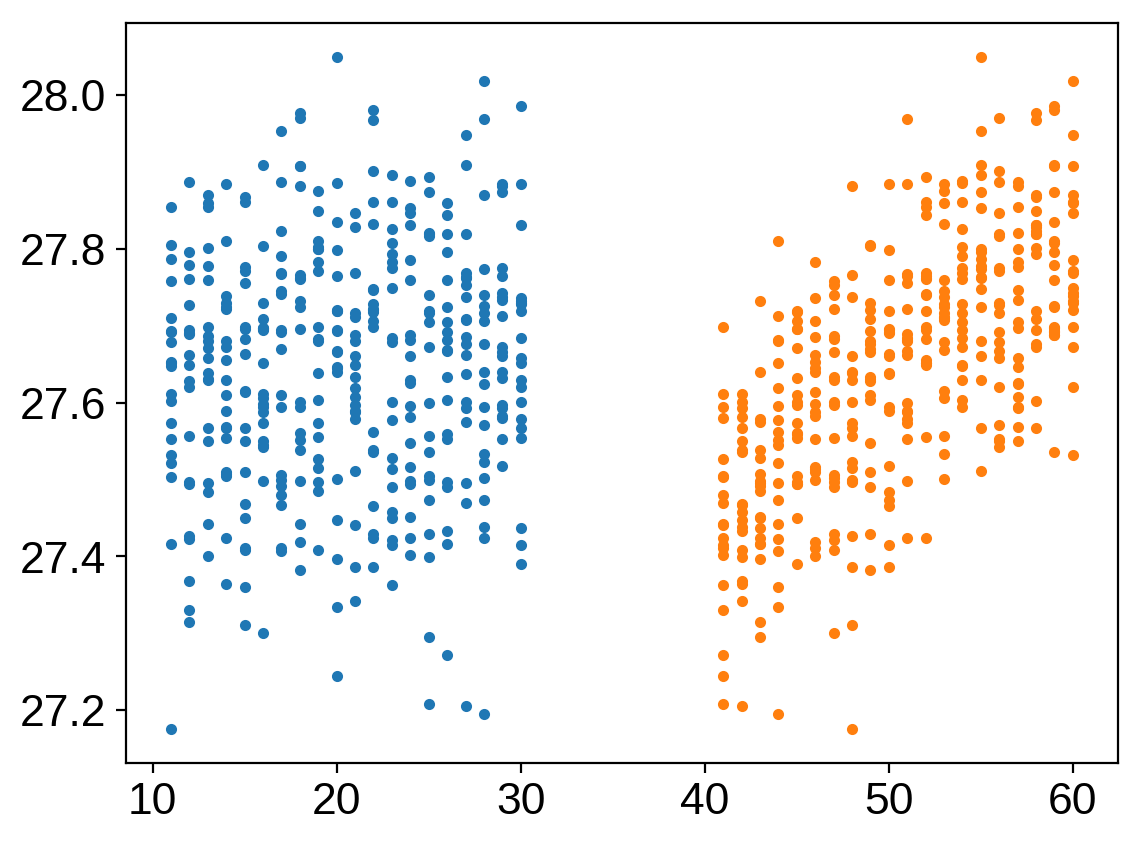

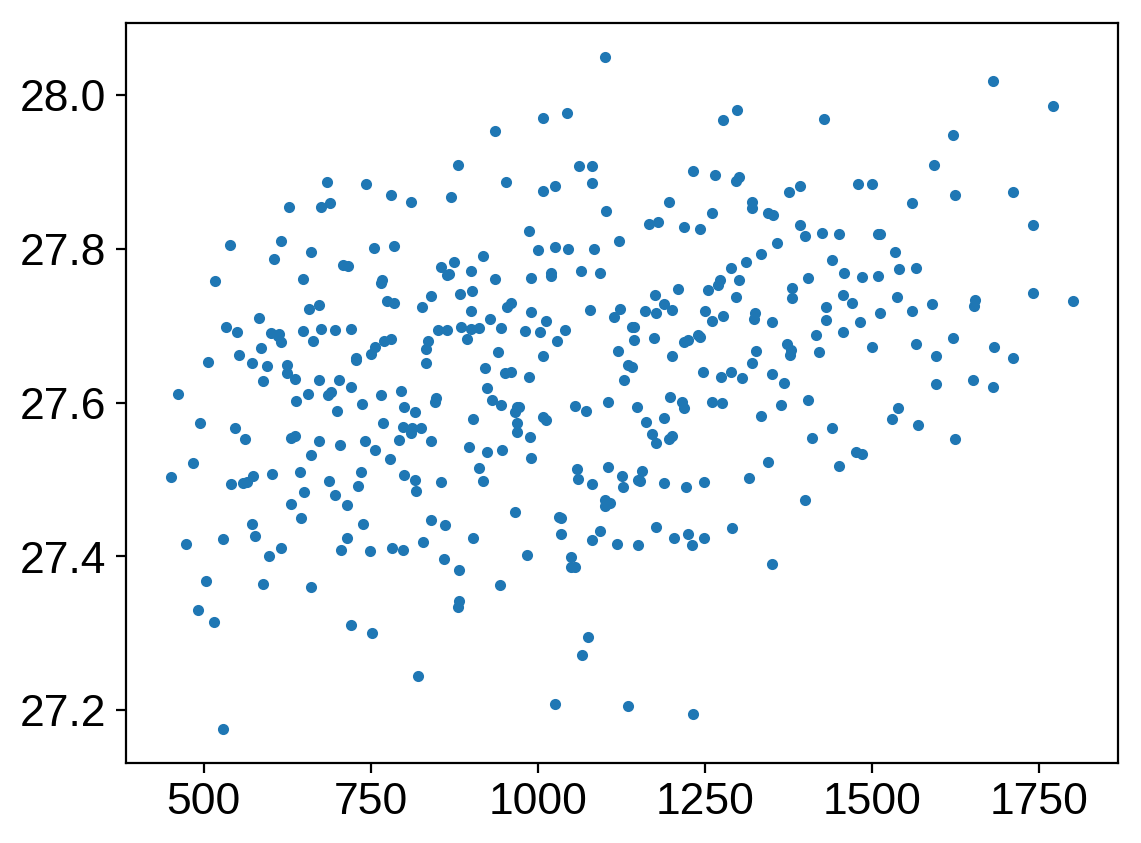

In [125]:
# mesh_widths_sorted = np.argsort(mesh_widths)
# mesh_heights_sorted = np.argsort(mesh_heights)
plt.plot(means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']), '.')
plt.plot(means_df['aper_height'], (means_df['edepth'] / uncs_df['edepth']),'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], (means_df['edepth'] / uncs_df['edepth']),'.')

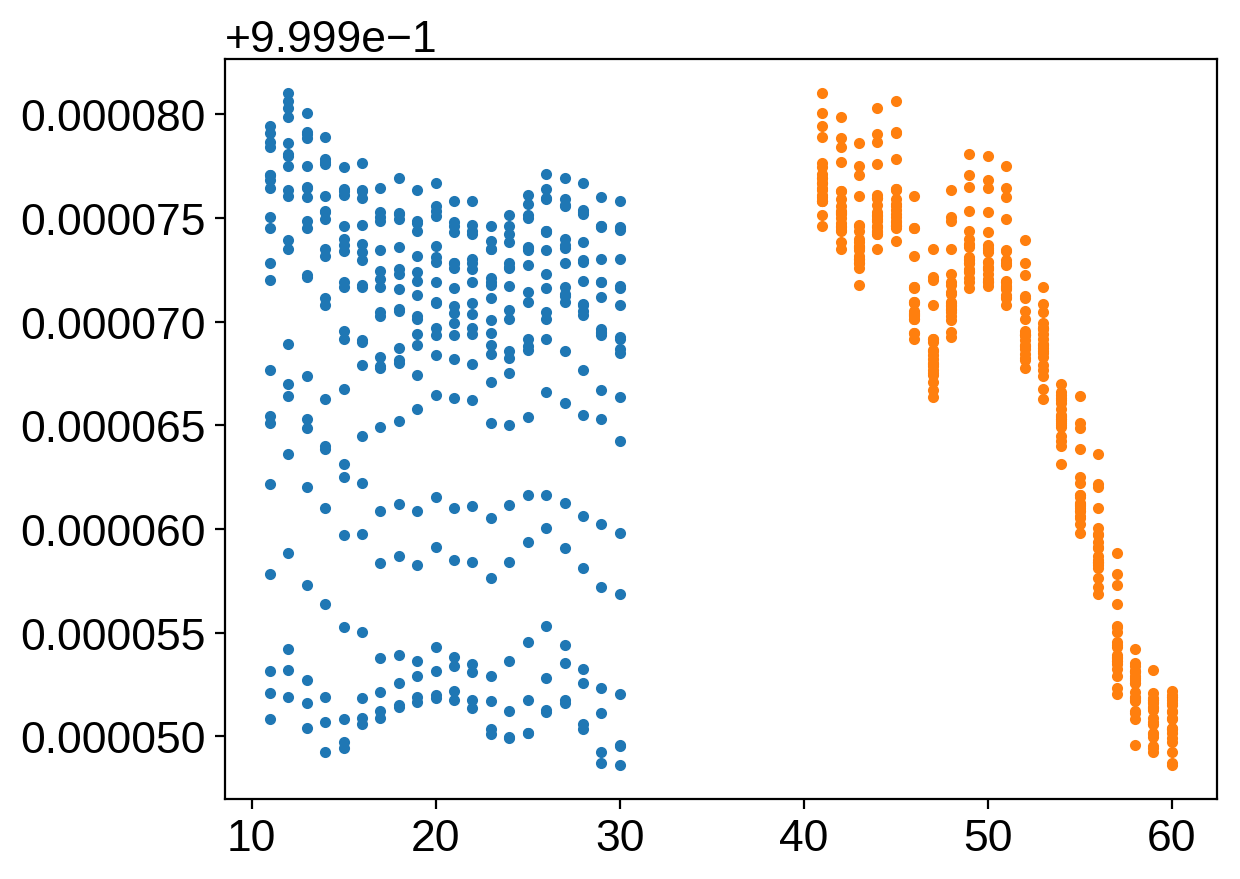

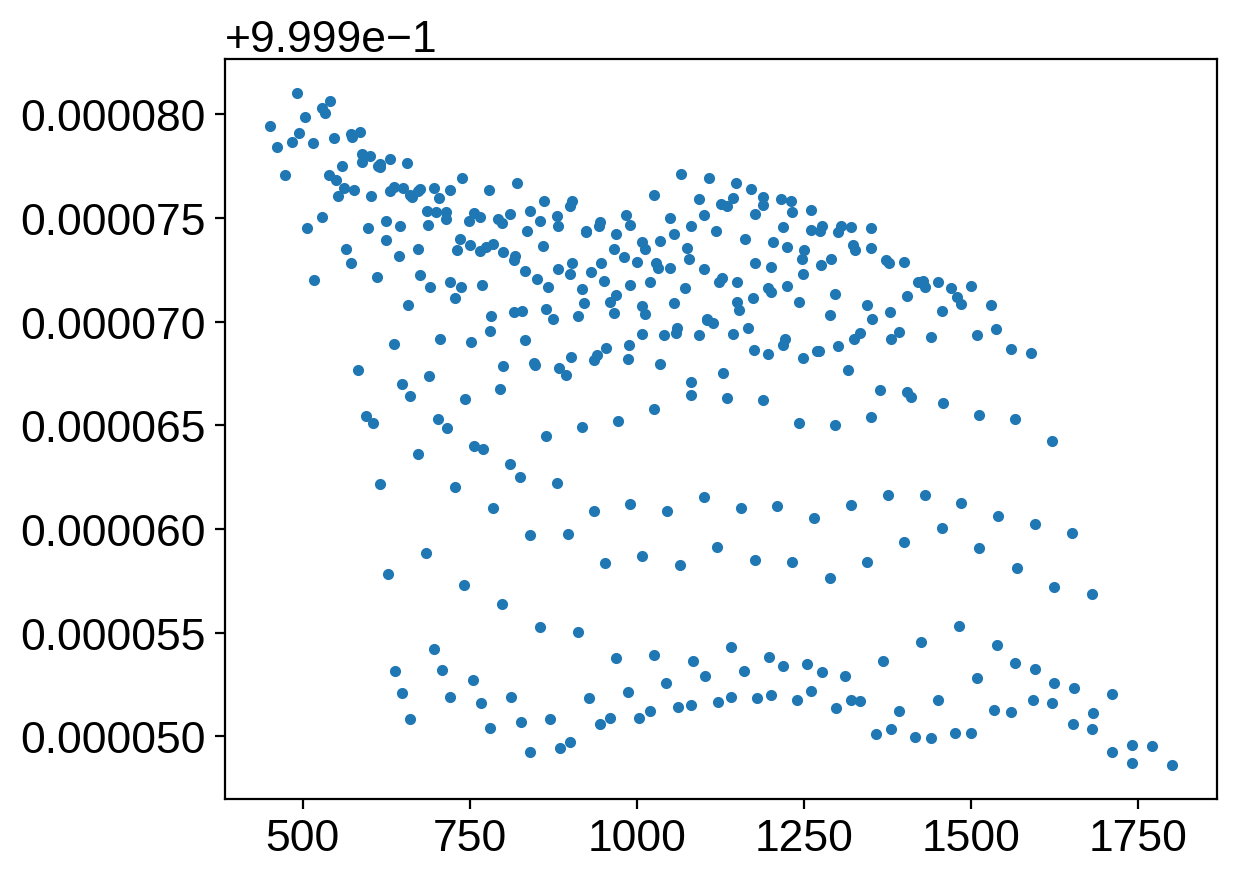

In [124]:
mesh_widths_sorted = np.argsort(mesh_widths)
mesh_heights_sorted = np.argsort(mesh_heights)

plt.figure()
plt.plot(means_df['aper_width'], means_df['mean'],'.')
plt.plot(means_df['aper_height'], means_df['mean'],'.')

plt.figure()
plt.plot(means_df['aper_height']*means_df['aper_width'], means_df['mean'],'.')

That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

In [ ]:
import pygtc
import corner

In [ ]:
trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']

In [ ]:
n_lightcurves_fwd = trace['light_curves_fwd'].shape[0]
light_curves_fwd = trace['light_curves_fwd'].reshape(trace['light_curves_fwd'].shape[:2])#trace['mean_fwd'][:,None]

n_lightcurves_rev = trace['light_curves_rev'].shape[0]
light_curves_rev = trace['light_curves_rev'].reshape(trace['light_curves_rev'].shape[:2])#trace['mean_rev'][:,None]

for k in np.random.choice(np.arange(n_lightcurves_fwd), size=100):
    plt.plot(t[idx_fwd], light_curves_fwd[k], '.', color='C0', alpha=0.25)

for k in np.random.choice(np.arange(n_lightcurves_rev), size=100):
    plt.plot(t[idx_rev], light_curves_rev[k], '.', color='C1', alpha=0.25)

plt.ylim(-1e-5, 1e-6);
plt.xlim(t0_guess - 0.1, t0_guess + 0.1);

In [ ]:
for colname in tqdm(aper_sum_columns):
    trace = fine_grain_mcmcs_w_xcenterfit[colname]['trace']
    
    samples = pm.trace_to_dataframe(trace, varnames=varnames)
    truth = [0.0, 1.0, 1.0, 0.0]
    corner.corner(samples, truths=truth, labels=varnames);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

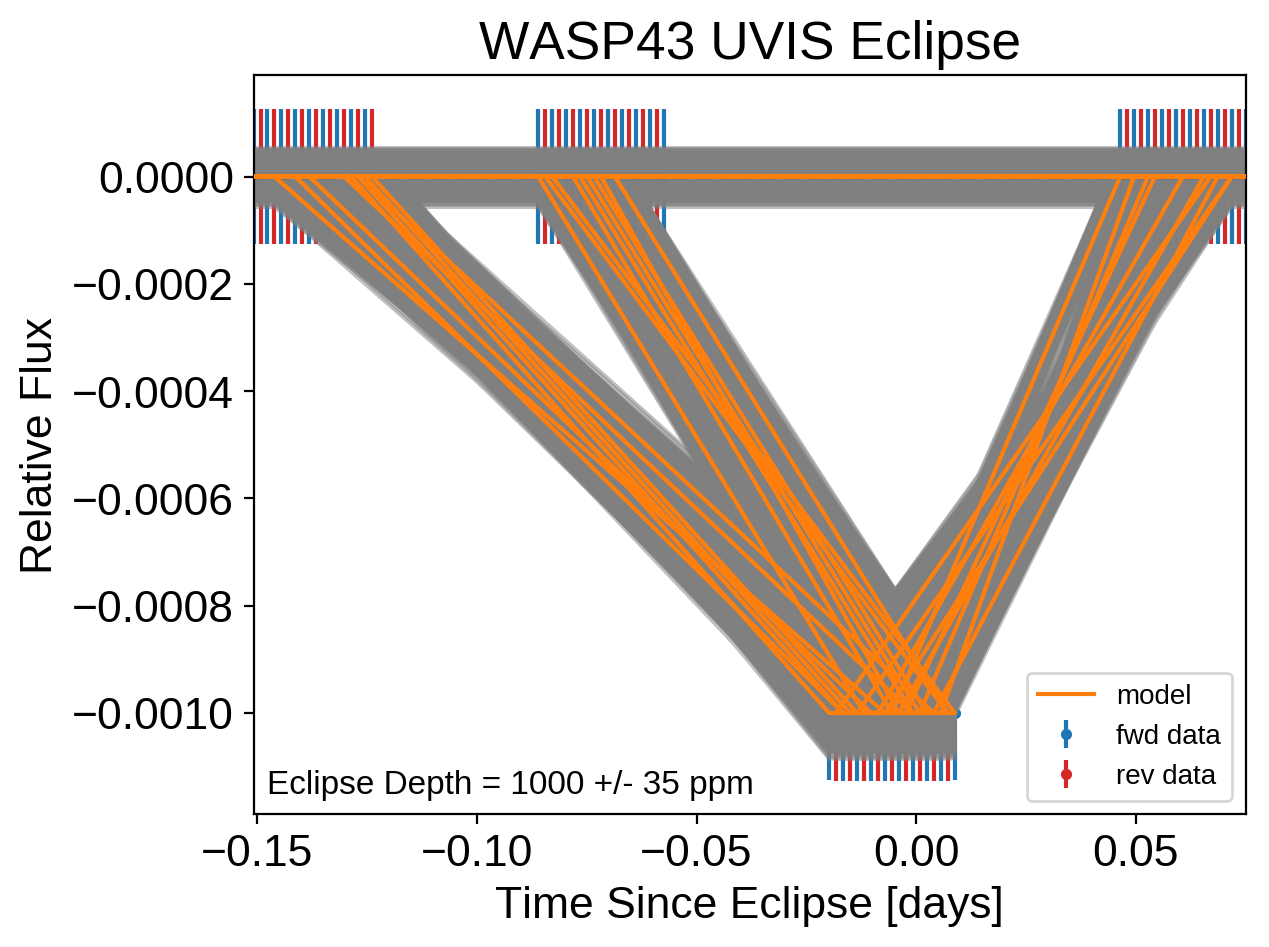

In [107]:
t = times
plt.figure()
# Get the posterior median orbital parameters
p = period
# t0 = np.median(trace["t0"])

# Plot the folded data
plt.errorbar(t[idx_fwd] - t0, data[idx_fwd], yerr=yerr[idx_fwd], fmt=".", color='C0', label="fwd data", zorder=-1000)
plt.errorbar(t[idx_rev] - t0, data[idx_rev], yerr=yerr[idx_rev], fmt=".", color='C3', label="rev data", zorder=-1000)

# Plot the folded model
preds_fwd = trace["light_curves"][:,:,0] + trace["mean"][:, None]# + trace["mean"][:, None]
# preds_rev = trace["light_curves"][:,:,0] + trace["mean"][:, None]
pred_fwd = np.median(preds_fwd, axis=0)
# pred_rev = np.median(preds_rev, axis=0)


plt.plot(times - t0, pred_fwd, color="C1", label="model", zorder=10)
# plt.plot(t[idx_rev] - t0, pred_rev, color="C2", label="model", zorder=10)
plt.axhline(0.0, ls='--', color='k')

# Annotate the plot with the planet's period
txt = f"Eclipse Depth = {np.mean(trace['edepth']*1e6):.0f}"
txt += f" +/- {np.std(trace['edepth']*1e6):.0f} ppm"

plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

add_traces = True
if add_traces:
    n_traces = 1000
    
    idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    for pred_ in preds_fwd[idx_rand]:
        plt.plot(times - t0, pred_, color="grey", alpha=0.5, zorder=0)

    # idx_rand = np.random.choice(np.arange(preds_fwd.shape[0]), size=n_traces, replace=False)
    # for pred_ in preds_rev[idx_rand]:
    #     plt.plot(t[idx_rev] - t0, pred_, color="grey", alpha=0.5, zorder=0)

plt.legend(fontsize=10, loc=4)
plt.xlim((t - t0).min(), (t - t0).max())
plt.xlabel("Time Since Eclipse [days]")
plt.ylabel("Relative Flux")
plt.title("WASP43 UVIS Eclipse");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print("\n".join(bib.splitlines()[:10]) + "\n...")